# Deep cortical reinforcement learning: Policy gradients + Q-learning + GAN


In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import gym

## Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('MountainCarContinuous-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [3]:
env.reset()
batch = []
for _ in range(1111):
    #env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    batch.append([action, state, reward, done, info])
    #print('state, action, reward, done, info:', state, action, reward, done, info)
    if done:
        env.reset()

To shut the window showing the simulation, use `env.close()`.

In [4]:
# env.close()

If you ran the simulation above, we can look at the rewards:

In [5]:
batch[0], 
batch[0][1].shape, state.shape

((4,), (4,))

In [6]:
import numpy as np
actions = np.array([each[0] for each in batch])
states = np.array([each[1] for each in batch])
rewards = np.array([each[2] for each in batch])
dones = np.array([each[3] for each in batch])
infos = np.array([each[4] for each in batch])

In [7]:
# print(rewards[-20:])
print('shapes:', np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print('dtypes:', np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print('states:', np.max(np.array(states)), np.min(np.array(states)))
print('actions:', np.max(np.array(actions)), np.min(np.array(actions)))
# print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
print('rewards:', np.max(np.array(rewards)), np.min(np.array(rewards)))

shapes: (1111,) (1111, 4) (1111,) (1111,)
dtypes: float64 float64 int64 bool
states: 2.6156247714885117 -2.4988433310700557
actions: 1 0
rewards: 1.0 1.0


In [8]:
actions[:10]

array([0, 1, 1, 0, 1, 1, 1, 1, 1, 1])

In [9]:
rewards[:10]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [10]:
# import numpy as np
def sigmoid(x, derivative=False):
  return x*(1-x) if derivative else 1/(1+np.exp(-x))

In [11]:
sigmoid(np.max(np.array(rewards))), sigmoid(np.min(np.array(rewards)))

(0.7310585786300049, 0.7310585786300049)

In [12]:
print('rewards:', np.max(np.array(rewards))/100, np.min(np.array(rewards))/100)

rewards: 0.01 0.01


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [13]:
# Data of the model
def model_input(state_size):
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    reward = tf.placeholder(tf.float32, [], name='reward')
    return states, actions, targetQs, reward

In [14]:
# How to use batch-norm
#   x_norm = tf.layers.batch_normalization(x, training=training)

#   # ...

#   update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
#   with tf.control_dependencies(update_ops):
#     train_op = optimizer.minimize(loss)

In [15]:
# training: Either a Python boolean, or a TensorFlow boolean scalar tensor (e.g. a placeholder). 
# Whether to return the output in: 
# training mode (normalized with statistics of the current batch) or 
# inference mode (normalized with moving statistics). 
# NOTE: make sure to set this parameter correctly, or else your training/inference will not work properly.

In [16]:
# Generator/Controller: Generating/prediting the actions
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [17]:
# Discriminator/Dopamine: Reward function/planner/naviator/advisor/supervisor/cortical columns
def discriminator(states, actions, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # Fusion/merge states and actions/ SA/ SM
        x_fused = tf.concat(axis=1, values=[states, actions])
        
        # First fully connected layer
        h1 = tf.layers.dense(inputs=x_fused, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)        
        #predictions = tf.nn.softmax(logits)

        # return rewards logits
        return logits

In [19]:
def model_loss(action_size, hidden_size, states, actions, targetQs, reward):
    # G
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    neg_log_prob_actions = tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, 
                                                                      labels=actions_labels)
    rewards = reward * tf.ones_like(targetQs)
    #Qs_labels = targetQs[1:]
    Qs_labels = rewards[:-1] + (0.99*targetQs[1:])
    #Qs_labels = tf.concat(axis=0, values=[Qs_labels, tf.zeros([1])])
    #g_loss = tf.reduce_mean(neg_log_prob_actions * Qs_labels)
    g_loss = tf.reduce_mean(neg_log_prob_actions[:-1] * Qs_labels)
    
    # D
    Qs_logits = discriminator(actions=actions_logits, hidden_size=hidden_size, states=states)
    d_lossR = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=tf.reshape(Qs_logits, [-1]),
                                                                     labels=rewards))
    # d_lossQ = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=tf.reshape(Qs_logits, [-1]),
    #                                                                  labels=tf.nn.sigmoid(Qs_labels)))
    d_lossQ = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=tf.reshape(Qs_logits[:-1], [-1]),
                                                                     labels=tf.nn.sigmoid(Qs_labels)))
    d_loss = d_lossR + d_lossQ

    return actions_logits, Qs_logits, g_loss, d_loss, d_lossR, d_lossQ

In [20]:
# Optimizating/training/learning G & D
def model_opt(g_loss, d_loss, learning_rate):
    """
    Get optimization operations in order
    :param g_loss: Generator loss Tensor for action prediction
    :param d_loss: Discriminator loss Tensor for reward prediction for generated/prob/logits action
    :param learning_rate: Learning Rate Placeholder
    :return: A tuple of (qfunction training, generator training, discriminator training)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        g_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)
        d_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)

    return g_opt, d_opt

In [21]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.targetQs, self.reward = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.Qs_logits, self.g_loss, self.d_loss, self.d_lossR, self.d_lossQ = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, actions=self.actions, # model input
            targetQs=self.targetQs, reward=self.reward) # model input
        
        # Update the model: backward pass and backprop
        self.g_opt, self.d_opt = model_opt(g_loss=self.g_loss, d_loss=self.d_loss, learning_rate=learning_rate)

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [22]:
print('state size:{}'.format(states.shape), 
      'actions:{}'.format(actions.shape)) 
print('action size:{}'.format(np.max(actions) - np.min(actions)+1))

state size:(1111, 4) actions:(1111,)
action size:2


In [23]:
# Training parameters
# Network parameters
state_size = 4               # number of units for the input state/observation -- simulation
action_size = 2              # number of units for the output actions -- simulation
hidden_size = 64             # number of units in each Q-network hidden layer -- simulation
learning_rate = 0.001          # learning rate for adam

In [24]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [25]:
# import gym

# ## Create the Cart-Pole game environment
# env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# # env = gym.make('MountainCar-v0')
# # env = gym.make('Pendulum-v0')
# # env = gym.make('Blackjack-v0')
# # env = gym.make('FrozenLake-v0')
# # env = gym.make('AirRaid-ram-v0')
# # env = gym.make('AirRaid-v0')
# # env = gym.make('BipedalWalker-v2')
# # env = gym.make('Copy-v0')
# # env = gym.make('CarRacing-v0')
# # env = gym.make('Ant-v2') #mujoco
# # env = gym.make('FetchPickAndPlace-v1') # mujoco required!

In [31]:
from collections import deque
episodes_total_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window
saver = tf.train.Saver()
rewards_list, g_loss_list, d_loss_list = [], [], []
rates_list, d_lossR_list, d_lossQ_list = [], [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Training episodes/epochs
    for ep in range(111111):
        batch = [] # every data batch
        total_reward = 0
        state = env.reset() # env first state

        # Training steps/batches
        while True:
            action_logits, Q_logits = sess.run(fetches=[model.actions_logits, model.Qs_logits], 
                                               feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            batch.append([state, action, Q_logits])
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done is True: # episode ended success/failure
                episodes_total_reward.append(total_reward) # stopping criteria
                rate = total_reward/ 500 # success is 500 points: 0-1
                break

        # Training using batches
        #batch = memory.buffer
        states = np.array([each[0] for each in batch])
        actions = np.array([each[1] for each in batch])
        targetQs = np.array([each[2] for each in batch])
        g_loss, d_loss, d_lossR, d_lossQ, _, _ = sess.run([model.g_loss, model.d_loss, 
                                                           model.d_lossR, model.d_lossQ, 
                                                           model.g_opt, model.d_opt],
                                                          feed_dict = {model.states: states, 
                                                                       model.actions: actions,
                                                                       model.reward: rate,
                                                                       model.targetQs: targetQs.reshape([-1])})
        # Average 100 episode total reward
        # Print out
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episodes_total_reward)),
              'rate:{:.4f}'.format(rate),
              'gloss:{:.4f}'.format(g_loss),
              'dloss:{:.4f}'.format(d_loss),
              'dlossR:{:.4f}'.format(d_lossR),
              'dlossQ:{:.4f}'.format(d_lossQ))
        # Ploting out
        rewards_list.append([ep, np.mean(episodes_total_reward)])
        rates_list.append([ep, rate])
        g_loss_list.append([ep, g_loss])
        d_loss_list.append([ep, d_loss])
        d_lossR_list.append([ep, d_lossR])
        d_lossQ_list.append([ep, d_lossQ])
        # Break episode/epoch loop
        if np.mean(episodes_total_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model2.ckpt')

Episode:0 meanR:49.0000 rate:0.0980 gloss:0.0893 dloss:1.3988 dlossR:0.7063 dlossQ:0.6925
Episode:1 meanR:48.5000 rate:0.0960 gloss:0.0697 dloss:1.3889 dlossR:0.6957 dlossQ:0.6931
Episode:2 meanR:48.3333 rate:0.0960 gloss:0.0523 dloss:1.3792 dlossR:0.6856 dlossQ:0.6936
Episode:3 meanR:48.2500 rate:0.0960 gloss:0.0293 dloss:1.3664 dlossR:0.6723 dlossQ:0.6941
Episode:4 meanR:44.0000 rate:0.0540 gloss:-0.0187 dloss:1.3506 dlossR:0.6572 dlossQ:0.6934
Episode:5 meanR:40.8333 rate:0.0500 gloss:-0.0415 dloss:1.3369 dlossR:0.6440 dlossQ:0.6930
Episode:6 meanR:38.5714 rate:0.0500 gloss:-0.0507 dloss:1.3312 dlossR:0.6385 dlossQ:0.6927
Episode:7 meanR:37.8750 rate:0.0660 gloss:-0.0854 dloss:1.3055 dlossR:0.6141 dlossQ:0.6915
Episode:8 meanR:36.0000 rate:0.0420 gloss:-0.1423 dloss:1.2741 dlossR:0.5863 dlossQ:0.6878
Episode:9 meanR:35.5000 rate:0.0620 gloss:-0.1080 dloss:1.2924 dlossR:0.6018 dlossQ:0.6906
Episode:10 meanR:35.6364 rate:0.0740 gloss:-0.1217 dloss:1.2824 dlossR:0.5926 dlossQ:0.6897
Ep

Episode:90 meanR:43.4725 rate:0.0220 gloss:-2.1096 dloss:0.3285 dlossR:0.1298 dlossQ:0.1987
Episode:91 meanR:43.1196 rate:0.0220 gloss:-1.8770 dloss:0.3732 dlossR:0.1340 dlossQ:0.2392
Episode:92 meanR:42.7849 rate:0.0240 gloss:-1.7003 dloss:0.4274 dlossR:0.1466 dlossQ:0.2808
Episode:93 meanR:42.6809 rate:0.0660 gloss:-1.3700 dloss:0.6316 dlossR:0.2584 dlossQ:0.3732
Episode:94 meanR:42.4211 rate:0.0360 gloss:-1.3254 dloss:0.5859 dlossR:0.2022 dlossQ:0.3838
Episode:95 meanR:42.3021 rate:0.0620 gloss:-1.3358 dloss:0.6349 dlossR:0.2525 dlossQ:0.3823
Episode:96 meanR:42.1340 rate:0.0520 gloss:-1.2544 dloss:0.6486 dlossR:0.2405 dlossQ:0.4080
Episode:97 meanR:41.8571 rate:0.0300 gloss:-1.4849 dloss:0.5118 dlossR:0.1741 dlossQ:0.3378
Episode:98 meanR:41.5556 rate:0.0240 gloss:-1.7436 dloss:0.4146 dlossR:0.1445 dlossQ:0.2702
Episode:99 meanR:41.2700 rate:0.0260 gloss:-1.6733 dloss:0.4406 dlossR:0.1531 dlossQ:0.2874
Episode:100 meanR:40.8800 rate:0.0200 gloss:-1.8844 dloss:0.3713 dlossR:0.1296 d

Episode:181 meanR:58.3700 rate:0.1200 gloss:-0.8785 dloss:0.9214 dlossR:0.3962 dlossQ:0.5252
Episode:182 meanR:59.1700 rate:0.2100 gloss:-0.7655 dloss:1.0853 dlossR:0.5248 dlossQ:0.5606
Episode:183 meanR:59.7000 rate:0.1380 gloss:-0.9987 dloss:0.9019 dlossR:0.4140 dlossQ:0.4879
Episode:184 meanR:60.4200 rate:0.1920 gloss:-0.8921 dloss:1.0239 dlossR:0.5015 dlossQ:0.5224
Episode:185 meanR:61.2900 rate:0.2040 gloss:-0.8973 dloss:1.0395 dlossR:0.5183 dlossQ:0.5212
Episode:186 meanR:65.9100 rate:0.9540 gloss:-0.0239 dloss:2.0646 dlossR:1.2818 dlossQ:0.7829
Episode:187 meanR:66.9400 rate:0.2280 gloss:-0.9378 dloss:1.0682 dlossR:0.5587 dlossQ:0.5095
Episode:188 meanR:69.3500 rate:0.5020 gloss:-0.2118 dloss:1.4899 dlossR:0.7824 dlossQ:0.7074
Episode:189 meanR:70.6700 rate:0.2820 gloss:-0.3713 dloss:1.2660 dlossR:0.6007 dlossQ:0.6653
Episode:190 meanR:73.0500 rate:0.4980 gloss:-0.6356 dloss:1.5549 dlossR:0.9424 dlossQ:0.6125
Episode:191 meanR:76.2100 rate:0.6540 gloss:-0.5376 dloss:1.8259 dloss

Episode:278 meanR:53.2600 rate:0.1220 gloss:-1.6409 dloss:0.6795 dlossR:0.3853 dlossQ:0.2942
Episode:279 meanR:53.0000 rate:0.0600 gloss:-1.7498 dloss:0.4948 dlossR:0.2287 dlossQ:0.2661
Episode:280 meanR:52.5200 rate:0.0380 gloss:-1.8335 dloss:0.4138 dlossR:0.1683 dlossQ:0.2455
Episode:281 meanR:52.1100 rate:0.0380 gloss:-1.9169 dloss:0.3942 dlossR:0.1666 dlossQ:0.2276
Episode:282 meanR:51.2100 rate:0.0300 gloss:-1.9338 dloss:0.3699 dlossR:0.1447 dlossQ:0.2252
Episode:283 meanR:50.8200 rate:0.0600 gloss:-1.9635 dloss:0.4454 dlossR:0.2290 dlossQ:0.2164
Episode:284 meanR:49.9900 rate:0.0260 gloss:-2.0937 dloss:0.3186 dlossR:0.1277 dlossQ:0.1910
Episode:285 meanR:49.1300 rate:0.0320 gloss:-2.1391 dloss:0.3295 dlossR:0.1460 dlossQ:0.1835
Episode:286 meanR:44.4600 rate:0.0200 gloss:-2.2326 dloss:0.2774 dlossR:0.1088 dlossQ:0.1686
Episode:287 meanR:43.4500 rate:0.0260 gloss:-2.2905 dloss:0.2841 dlossR:0.1258 dlossQ:0.1583
Episode:288 meanR:41.0700 rate:0.0260 gloss:-2.3449 dloss:0.2763 dloss

Episode:378 meanR:28.8700 rate:0.4560 gloss:-1.6487 dloss:1.6626 dlossR:1.3628 dlossQ:0.2999
Episode:379 meanR:28.9400 rate:0.0740 gloss:-1.7542 dloss:0.5380 dlossR:0.2681 dlossQ:0.2698
Episode:380 meanR:28.8700 rate:0.0240 gloss:-2.4224 dloss:0.2634 dlossR:0.1202 dlossQ:0.1433
Episode:381 meanR:28.7800 rate:0.0200 gloss:-2.3155 dloss:0.2649 dlossR:0.1073 dlossQ:0.1577
Episode:382 meanR:28.8400 rate:0.0420 gloss:-1.8696 dloss:0.4252 dlossR:0.1818 dlossQ:0.2434
Episode:383 meanR:28.8400 rate:0.0600 gloss:-1.6152 dloss:0.5321 dlossR:0.2311 dlossQ:0.3010
Episode:384 meanR:29.1000 rate:0.0780 gloss:-1.6645 dloss:0.5614 dlossR:0.2745 dlossQ:0.2870
Episode:385 meanR:29.3600 rate:0.0840 gloss:-1.6621 dloss:0.5986 dlossR:0.2978 dlossQ:0.3008
Episode:386 meanR:29.7800 rate:0.1040 gloss:-1.6626 dloss:0.6287 dlossR:0.3408 dlossQ:0.2880
Episode:387 meanR:30.3600 rate:0.1420 gloss:-1.4995 dloss:0.7673 dlossR:0.4284 dlossQ:0.3389
Episode:388 meanR:30.9400 rate:0.1420 gloss:-1.5829 dloss:0.7419 dloss

Episode:468 meanR:57.9400 rate:0.1420 gloss:-0.8243 dloss:0.9701 dlossR:0.4239 dlossQ:0.5461
Episode:469 meanR:57.9100 rate:0.0280 gloss:-0.9430 dloss:0.7722 dlossR:0.2642 dlossQ:0.5080
Episode:470 meanR:57.8300 rate:0.0300 gloss:-0.9376 dloss:0.7776 dlossR:0.2679 dlossQ:0.5097
Episode:471 meanR:57.8300 rate:0.0280 gloss:-0.9732 dloss:0.7565 dlossR:0.2585 dlossQ:0.4979
Episode:472 meanR:57.7900 rate:0.0240 gloss:-0.9245 dloss:0.7796 dlossR:0.2660 dlossQ:0.5136
Episode:473 meanR:57.8100 rate:0.0320 gloss:-0.8386 dloss:0.8357 dlossR:0.2955 dlossQ:0.5402
Episode:474 meanR:57.8300 rate:0.0360 gloss:-0.8384 dloss:0.8407 dlossR:0.3003 dlossQ:0.5404
Episode:475 meanR:58.1600 rate:0.0980 gloss:-0.7987 dloss:0.9297 dlossR:0.3766 dlossQ:0.5531
Episode:476 meanR:58.8800 rate:0.1640 gloss:-0.7245 dloss:1.0376 dlossR:0.4609 dlossQ:0.5766
Episode:477 meanR:60.0200 rate:0.2820 gloss:-0.7631 dloss:1.1887 dlossR:0.6216 dlossQ:0.5671
Episode:478 meanR:58.7400 rate:0.2000 gloss:-0.6937 dloss:1.0923 dloss

Episode:559 meanR:106.9300 rate:0.3820 gloss:-0.5224 dloss:1.3625 dlossR:0.7184 dlossQ:0.6441
Episode:560 meanR:108.0000 rate:0.2400 gloss:-0.5305 dloss:1.1947 dlossR:0.5732 dlossQ:0.6215
Episode:561 meanR:108.7000 rate:0.1660 gloss:-0.6502 dloss:1.0770 dlossR:0.4814 dlossQ:0.5957
Episode:562 meanR:108.8300 rate:0.1520 gloss:-0.5661 dloss:1.0984 dlossR:0.4825 dlossQ:0.6159
Episode:563 meanR:107.9200 rate:0.0480 gloss:-0.8823 dloss:0.8254 dlossR:0.2995 dlossQ:0.5259
Episode:564 meanR:104.6900 rate:0.0560 gloss:-0.7863 dloss:0.8877 dlossR:0.3335 dlossQ:0.5542
Episode:565 meanR:99.9000 rate:0.0420 gloss:-0.7927 dloss:0.8683 dlossR:0.3154 dlossQ:0.5529
Episode:566 meanR:98.2600 rate:0.0420 gloss:-0.8826 dloss:0.8188 dlossR:0.2928 dlossQ:0.5260
Episode:567 meanR:97.6000 rate:0.0460 gloss:-0.9757 dloss:0.7729 dlossR:0.2762 dlossQ:0.4968
Episode:568 meanR:97.3400 rate:0.0900 gloss:-0.6949 dloss:0.9785 dlossR:0.3964 dlossQ:0.5822
Episode:569 meanR:97.4000 rate:0.0400 gloss:-1.0397 dloss:0.7320

Episode:648 meanR:72.5600 rate:0.0860 gloss:-1.0665 dloss:0.7929 dlossR:0.3239 dlossQ:0.4690
Episode:649 meanR:72.6800 rate:0.0740 gloss:-1.1135 dloss:0.7533 dlossR:0.2993 dlossQ:0.4540
Episode:650 meanR:72.8600 rate:0.0920 gloss:-1.0760 dloss:0.7984 dlossR:0.3320 dlossQ:0.4664
Episode:651 meanR:73.0300 rate:0.0840 gloss:-1.2218 dloss:0.7303 dlossR:0.3088 dlossQ:0.4216
Episode:652 meanR:73.2600 rate:0.0720 gloss:-1.4610 dloss:0.6388 dlossR:0.2819 dlossQ:0.3570
Episode:653 meanR:73.3100 rate:0.0340 gloss:-1.1664 dloss:0.6653 dlossR:0.2276 dlossQ:0.4377
Episode:654 meanR:73.3600 rate:0.0340 gloss:-1.1505 dloss:0.6749 dlossR:0.2314 dlossQ:0.4435
Episode:655 meanR:73.3700 rate:0.0260 gloss:-1.3082 dloss:0.5898 dlossR:0.1960 dlossQ:0.3938
Episode:656 meanR:73.2000 rate:0.0240 gloss:-1.3494 dloss:0.5690 dlossR:0.1877 dlossQ:0.3813
Episode:657 meanR:72.7100 rate:0.0220 gloss:-1.4849 dloss:0.5144 dlossR:0.1713 dlossQ:0.3431
Episode:658 meanR:72.7100 rate:0.0300 gloss:-1.4020 dloss:0.5610 dloss

Episode:743 meanR:78.7700 rate:0.0560 gloss:-1.1002 dloss:0.7322 dlossR:0.2716 dlossQ:0.4606
Episode:744 meanR:78.6900 rate:0.0820 gloss:-1.0849 dloss:0.7794 dlossR:0.3135 dlossQ:0.4658
Episode:745 meanR:78.4900 rate:0.0640 gloss:-1.1651 dloss:0.7152 dlossR:0.2751 dlossQ:0.4401
Episode:746 meanR:78.4200 rate:0.0720 gloss:-1.1666 dloss:0.7269 dlossR:0.2884 dlossQ:0.4385
Episode:747 meanR:78.3800 rate:0.0640 gloss:-1.2217 dloss:0.6897 dlossR:0.2692 dlossQ:0.4205
Episode:748 meanR:78.5500 rate:0.1200 gloss:-1.0899 dloss:0.8388 dlossR:0.3762 dlossQ:0.4626
Episode:749 meanR:78.5900 rate:0.0820 gloss:-1.3181 dloss:0.6893 dlossR:0.2975 dlossQ:0.3918
Episode:750 meanR:79.5200 rate:0.2780 gloss:-0.6758 dloss:1.2056 dlossR:0.6116 dlossQ:0.5940
Episode:751 meanR:80.7400 rate:0.3280 gloss:-1.0442 dloss:1.2446 dlossR:0.7585 dlossQ:0.4861
Episode:752 meanR:81.0900 rate:0.1420 gloss:-0.9464 dloss:0.9269 dlossR:0.4167 dlossQ:0.5102
Episode:753 meanR:81.3900 rate:0.0940 gloss:-1.0992 dloss:0.7984 dloss

Episode:833 meanR:34.1800 rate:0.0380 gloss:-1.6995 dloss:0.4663 dlossR:0.1789 dlossQ:0.2874
Episode:834 meanR:34.0700 rate:0.0400 gloss:-1.7565 dloss:0.4507 dlossR:0.1794 dlossQ:0.2713
Episode:835 meanR:33.9800 rate:0.0360 gloss:-1.9071 dloss:0.4013 dlossR:0.1640 dlossQ:0.2373
Episode:836 meanR:34.0100 rate:0.0480 gloss:-1.7753 dloss:0.4656 dlossR:0.1988 dlossQ:0.2667
Episode:837 meanR:34.0600 rate:0.0480 gloss:-1.7334 dloss:0.4764 dlossR:0.1999 dlossQ:0.2765
Episode:838 meanR:34.0200 rate:0.0460 gloss:-1.7302 dloss:0.4699 dlossR:0.1949 dlossQ:0.2750
Episode:839 meanR:34.1300 rate:0.0720 gloss:-1.6539 dloss:0.5593 dlossR:0.2627 dlossQ:0.2966
Episode:840 meanR:34.1800 rate:0.0780 gloss:-2.0999 dloss:0.5457 dlossR:0.3098 dlossQ:0.2359
Episode:841 meanR:34.2500 rate:0.0680 gloss:-1.7351 dloss:0.5250 dlossR:0.2513 dlossQ:0.2737
Episode:842 meanR:34.4500 rate:0.1120 gloss:-2.0779 dloss:0.6550 dlossR:0.4151 dlossQ:0.2398
Episode:843 meanR:34.6800 rate:0.1020 gloss:-2.1342 dloss:0.6226 dloss

Episode:925 meanR:46.9500 rate:1.0000 gloss:-0.5234 dloss:2.6551 dlossR:1.9303 dlossQ:0.7248
Episode:926 meanR:49.3200 rate:0.4980 gloss:-0.7608 dloss:1.5732 dlossR:0.9892 dlossQ:0.5840
Episode:927 meanR:50.0900 rate:0.1760 gloss:-0.9290 dloss:0.9827 dlossR:0.4686 dlossQ:0.5141
Episode:928 meanR:50.5600 rate:0.1220 gloss:-1.0633 dloss:0.8494 dlossR:0.3789 dlossQ:0.4705
Episode:929 meanR:50.5600 rate:0.0200 gloss:-1.7455 dloss:0.4216 dlossR:0.1440 dlossQ:0.2776
Episode:930 meanR:51.2100 rate:0.1520 gloss:-0.8613 dloss:0.9703 dlossR:0.4359 dlossQ:0.5344
Episode:931 meanR:52.1100 rate:0.2200 gloss:-1.0388 dloss:1.0328 dlossR:0.5508 dlossQ:0.4820
Episode:932 meanR:52.2900 rate:0.0820 gloss:-1.1944 dloss:0.7536 dlossR:0.3160 dlossQ:0.4376
Episode:933 meanR:52.3200 rate:0.0440 gloss:-1.2747 dloss:0.6344 dlossR:0.2286 dlossQ:0.4057
Episode:934 meanR:52.2900 rate:0.0340 gloss:-1.4814 dloss:0.5391 dlossR:0.1914 dlossQ:0.3477
Episode:935 meanR:52.2600 rate:0.0300 gloss:-1.3711 dloss:0.5689 dloss

Episode:1019 meanR:66.7100 rate:0.0520 gloss:-1.2050 dloss:0.6799 dlossR:0.2515 dlossQ:0.4284
Episode:1020 meanR:66.5400 rate:0.0380 gloss:-1.2831 dloss:0.6215 dlossR:0.2179 dlossQ:0.4036
Episode:1021 meanR:66.5800 rate:0.0580 gloss:-1.2020 dloss:0.6889 dlossR:0.2619 dlossQ:0.4270
Episode:1022 meanR:68.2800 rate:0.4100 gloss:-0.7590 dloss:1.4037 dlossR:0.8231 dlossQ:0.5806
Episode:1023 meanR:68.9100 rate:0.1460 gloss:-1.1220 dloss:0.8706 dlossR:0.4182 dlossQ:0.4524
Episode:1024 meanR:68.9400 rate:0.1260 gloss:-1.2160 dloss:0.8053 dlossR:0.3822 dlossQ:0.4231
Episode:1025 meanR:64.4200 rate:0.0960 gloss:-1.2496 dloss:0.7392 dlossR:0.3260 dlossQ:0.4132
Episode:1026 meanR:62.4100 rate:0.0960 gloss:-1.2904 dloss:0.7238 dlossR:0.3236 dlossQ:0.4002
Episode:1027 meanR:62.0600 rate:0.1060 gloss:-1.2581 dloss:0.7544 dlossR:0.3442 dlossQ:0.4102
Episode:1028 meanR:62.0400 rate:0.1180 gloss:-1.1219 dloss:0.8217 dlossR:0.3685 dlossQ:0.4532
Episode:1029 meanR:62.9300 rate:0.1980 gloss:-0.9447 dloss:1

Episode:1110 meanR:40.7100 rate:0.0640 gloss:-1.4926 dloss:0.5895 dlossR:0.2474 dlossQ:0.3421
Episode:1111 meanR:40.8600 rate:0.0660 gloss:-1.4709 dloss:0.6015 dlossR:0.2532 dlossQ:0.3483
Episode:1112 meanR:41.0400 rate:0.0580 gloss:-1.5025 dloss:0.5724 dlossR:0.2340 dlossQ:0.3384
Episode:1113 meanR:41.2300 rate:0.0660 gloss:-1.4658 dloss:0.6016 dlossR:0.2531 dlossQ:0.3485
Episode:1114 meanR:41.4800 rate:0.0860 gloss:-1.4671 dloss:0.6451 dlossR:0.2966 dlossQ:0.3485
Episode:1115 meanR:41.7000 rate:0.0940 gloss:-1.4253 dloss:0.6745 dlossR:0.3146 dlossQ:0.3599
Episode:1116 meanR:41.7400 rate:0.0860 gloss:-1.4054 dloss:0.6628 dlossR:0.2978 dlossQ:0.3650
Episode:1117 meanR:41.1100 rate:0.0740 gloss:-1.4469 dloss:0.6243 dlossR:0.2710 dlossQ:0.3533
Episode:1118 meanR:41.7400 rate:0.1680 gloss:-1.2250 dloss:0.8795 dlossR:0.4614 dlossQ:0.4181
Episode:1119 meanR:42.2300 rate:0.1500 gloss:-1.3348 dloss:0.8191 dlossR:0.4327 dlossQ:0.3864
Episode:1120 meanR:42.5600 rate:0.1040 gloss:-1.3761 dloss:0

Episode:1199 meanR:70.0800 rate:0.2940 gloss:0.1253 dloss:1.3743 dlossR:0.6982 dlossQ:0.6761
Episode:1200 meanR:71.0000 rate:0.3320 gloss:0.2145 dloss:1.3873 dlossR:0.7067 dlossQ:0.6807
Episode:1201 meanR:72.8700 rate:0.4740 gloss:0.2994 dloss:1.3934 dlossR:0.7082 dlossQ:0.6851
Episode:1202 meanR:75.8000 rate:0.6760 gloss:0.4250 dloss:1.4120 dlossR:0.7204 dlossQ:0.6916
Episode:1203 meanR:80.3900 rate:1.0000 gloss:0.5407 dloss:1.5545 dlossR:0.8134 dlossQ:0.7412
Episode:1204 meanR:85.0600 rate:1.0000 gloss:0.5141 dloss:1.5829 dlossR:0.8354 dlossQ:0.7475
Episode:1205 meanR:86.6300 rate:0.3880 gloss:-0.1253 dloss:1.3779 dlossR:0.6705 dlossQ:0.7074
Episode:1206 meanR:91.3700 rate:1.0000 gloss:0.5721 dloss:1.5189 dlossR:0.7867 dlossQ:0.7322
Episode:1207 meanR:92.9700 rate:0.3820 gloss:-0.0468 dloss:1.3764 dlossR:0.6669 dlossQ:0.7095
Episode:1208 meanR:94.0600 rate:0.2700 gloss:-0.0729 dloss:1.3253 dlossR:0.6265 dlossQ:0.6988
Episode:1209 meanR:98.0600 rate:0.8680 gloss:0.4555 dloss:1.5102 dl

Episode:1288 meanR:116.9600 rate:0.0700 gloss:-1.2816 dloss:0.6777 dlossR:0.2736 dlossQ:0.4041
Episode:1289 meanR:112.2400 rate:0.0560 gloss:-1.3666 dloss:0.6188 dlossR:0.2405 dlossQ:0.3783
Episode:1290 meanR:109.8300 rate:0.0420 gloss:-1.4573 dloss:0.5555 dlossR:0.2046 dlossQ:0.3509
Episode:1291 meanR:107.8800 rate:0.0500 gloss:-1.4534 dloss:0.5756 dlossR:0.2225 dlossQ:0.3531
Episode:1292 meanR:106.6500 rate:0.0620 gloss:-1.3899 dloss:0.6231 dlossR:0.2514 dlossQ:0.3718
Episode:1293 meanR:105.7600 rate:0.0500 gloss:-1.4436 dloss:0.5784 dlossR:0.2229 dlossQ:0.3555
Episode:1294 meanR:105.0600 rate:0.0620 gloss:-1.3793 dloss:0.6285 dlossR:0.2529 dlossQ:0.3756
Episode:1295 meanR:104.5500 rate:0.0600 gloss:-1.4201 dloss:0.6113 dlossR:0.2472 dlossQ:0.3641
Episode:1296 meanR:104.8500 rate:0.0800 gloss:-1.2159 dloss:0.7219 dlossR:0.2979 dlossQ:0.4240
Episode:1297 meanR:104.7900 rate:0.1660 gloss:-1.0770 dloss:0.9213 dlossR:0.4532 dlossQ:0.4681
Episode:1298 meanR:104.6400 rate:0.2160 gloss:-1.0

Episode:1379 meanR:52.6600 rate:0.0640 gloss:-1.4136 dloss:0.6162 dlossR:0.2533 dlossQ:0.3629
Episode:1380 meanR:52.9300 rate:0.0820 gloss:-1.3812 dloss:0.6643 dlossR:0.2920 dlossQ:0.3724
Episode:1381 meanR:53.1500 rate:0.0940 gloss:-1.3448 dloss:0.6999 dlossR:0.3175 dlossQ:0.3825
Episode:1382 meanR:53.8100 rate:0.1980 gloss:-1.1309 dloss:0.9648 dlossR:0.5146 dlossQ:0.4502
Episode:1383 meanR:54.7900 rate:0.3880 gloss:-0.9642 dloss:1.3684 dlossR:0.8544 dlossQ:0.5140
Episode:1384 meanR:54.7900 rate:0.3980 gloss:-0.8101 dloss:1.3820 dlossR:0.8183 dlossQ:0.5637
Episode:1385 meanR:54.9600 rate:0.3140 gloss:-0.7560 dloss:1.2394 dlossR:0.6653 dlossQ:0.5741
Episode:1386 meanR:54.9100 rate:0.0960 gloss:-1.1650 dloss:0.7688 dlossR:0.3295 dlossQ:0.4393
Episode:1387 meanR:54.8500 rate:0.0900 gloss:-1.1682 dloss:0.7592 dlossR:0.3198 dlossQ:0.4393
Episode:1388 meanR:54.8800 rate:0.0760 gloss:-1.1780 dloss:0.7344 dlossR:0.2970 dlossQ:0.4374
Episode:1389 meanR:55.0500 rate:0.0900 gloss:-1.1492 dloss:0

Episode:1467 meanR:86.3400 rate:0.3280 gloss:-0.7655 dloss:1.2614 dlossR:0.6902 dlossQ:0.5712
Episode:1468 meanR:86.3700 rate:0.2260 gloss:-0.8630 dloss:1.0795 dlossR:0.5428 dlossQ:0.5367
Episode:1469 meanR:86.2700 rate:0.0740 gloss:-1.0998 dloss:0.7691 dlossR:0.3086 dlossQ:0.4606
Episode:1470 meanR:86.6900 rate:0.1160 gloss:-0.9641 dloss:0.8839 dlossR:0.3815 dlossQ:0.5024
Episode:1471 meanR:86.6200 rate:0.0240 gloss:-1.4314 dloss:0.5391 dlossR:0.1808 dlossQ:0.3583
Episode:1472 meanR:87.5400 rate:0.2220 gloss:-0.7344 dloss:1.1110 dlossR:0.5370 dlossQ:0.5740
Episode:1473 meanR:87.4200 rate:0.0160 gloss:-1.6441 dloss:0.4636 dlossR:0.1550 dlossQ:0.3086
Episode:1474 meanR:88.5100 rate:0.2500 gloss:-0.5770 dloss:1.1873 dlossR:0.5685 dlossQ:0.6188
Episode:1475 meanR:89.3200 rate:0.1940 gloss:-0.8431 dloss:1.0365 dlossR:0.4951 dlossQ:0.5414
Episode:1476 meanR:89.2500 rate:0.0220 gloss:-1.4549 dloss:0.5308 dlossR:0.1784 dlossQ:0.3524
Episode:1477 meanR:89.1800 rate:0.0200 gloss:-1.5191 dloss:0

Episode:1557 meanR:70.3200 rate:0.1000 gloss:-1.0749 dloss:0.8110 dlossR:0.3426 dlossQ:0.4685
Episode:1558 meanR:70.5400 rate:0.1100 gloss:-1.0182 dloss:0.8547 dlossR:0.3674 dlossQ:0.4873
Episode:1559 meanR:74.8900 rate:1.0000 gloss:0.2470 dloss:1.8788 dlossR:1.0792 dlossQ:0.7996
Episode:1560 meanR:76.6300 rate:0.4140 gloss:-0.1988 dloss:1.4010 dlossR:0.7157 dlossQ:0.6853
Episode:1561 meanR:78.4000 rate:0.3860 gloss:-0.3168 dloss:1.3735 dlossR:0.7085 dlossQ:0.6651
Episode:1562 meanR:79.1200 rate:0.2860 gloss:-0.3050 dloss:1.2871 dlossR:0.6275 dlossQ:0.6596
Episode:1563 meanR:80.1400 rate:0.2880 gloss:-0.4278 dloss:1.2662 dlossR:0.6263 dlossQ:0.6399
Episode:1564 meanR:79.5900 rate:0.1640 gloss:-0.4963 dloss:1.1380 dlossR:0.5324 dlossQ:0.6056
Episode:1565 meanR:78.4400 rate:0.0420 gloss:-1.2126 dloss:0.6591 dlossR:0.2351 dlossQ:0.4240
Episode:1566 meanR:77.2600 rate:0.0320 gloss:-1.2483 dloss:0.6281 dlossR:0.2157 dlossQ:0.4124
Episode:1567 meanR:75.7500 rate:0.0260 gloss:-1.3856 dloss:0.

Episode:1644 meanR:111.0300 rate:0.3400 gloss:-0.3118 dloss:1.3276 dlossR:0.6490 dlossQ:0.6786
Episode:1645 meanR:113.8900 rate:0.6300 gloss:-0.0811 dloss:1.6025 dlossR:0.8686 dlossQ:0.7339
Episode:1646 meanR:114.8000 rate:0.2360 gloss:-0.4489 dloss:1.2063 dlossR:0.5577 dlossQ:0.6487
Episode:1647 meanR:119.3900 rate:0.9460 gloss:0.6108 dloss:1.4345 dlossR:0.7334 dlossQ:0.7011
Episode:1648 meanR:124.2200 rate:1.0000 gloss:0.6260 dloss:1.4623 dlossR:0.7502 dlossQ:0.7121
Episode:1649 meanR:125.4200 rate:0.2780 gloss:-0.4258 dloss:1.2529 dlossR:0.5990 dlossQ:0.6539
Episode:1650 meanR:127.7900 rate:0.5120 gloss:-0.1523 dloss:1.4894 dlossR:0.7732 dlossQ:0.7162
Episode:1651 meanR:128.9800 rate:0.2660 gloss:-0.3932 dloss:1.2470 dlossR:0.5851 dlossQ:0.6618
Episode:1652 meanR:130.0400 rate:0.2480 gloss:-0.3755 dloss:1.2366 dlossR:0.5728 dlossQ:0.6638
Episode:1653 meanR:131.0800 rate:0.2580 gloss:-0.3550 dloss:1.2502 dlossR:0.5839 dlossQ:0.6664
Episode:1654 meanR:132.0000 rate:0.2280 gloss:-0.376

Episode:1736 meanR:155.6300 rate:0.0340 gloss:-1.3598 dloss:0.5877 dlossR:0.2066 dlossQ:0.3811
Episode:1737 meanR:155.3400 rate:0.0360 gloss:-1.2758 dloss:0.6296 dlossR:0.2227 dlossQ:0.4070
Episode:1738 meanR:154.9800 rate:0.0660 gloss:-1.1443 dloss:0.7445 dlossR:0.2935 dlossQ:0.4509
Episode:1739 meanR:154.2400 rate:0.0680 gloss:-1.2377 dloss:0.7050 dlossR:0.2833 dlossQ:0.4217
Episode:1740 meanR:154.2100 rate:0.2060 gloss:-0.6867 dloss:1.1021 dlossR:0.5119 dlossQ:0.5902
Episode:1741 meanR:154.2700 rate:0.1520 gloss:-0.6803 dloss:1.0425 dlossR:0.4544 dlossQ:0.5881
Episode:1742 meanR:153.7100 rate:0.1160 gloss:-0.7139 dloss:0.9897 dlossR:0.4131 dlossQ:0.5765
Episode:1743 meanR:153.1100 rate:0.0620 gloss:-0.8735 dloss:0.8533 dlossR:0.3242 dlossQ:0.5291
Episode:1744 meanR:152.2200 rate:0.1620 gloss:-0.8676 dloss:0.9940 dlossR:0.4579 dlossQ:0.5361
Episode:1745 meanR:149.4100 rate:0.0680 gloss:-0.8995 dloss:0.8469 dlossR:0.3247 dlossQ:0.5222
Episode:1746 meanR:148.5400 rate:0.0620 gloss:-0.8

Episode:1824 meanR:45.6100 rate:0.4560 gloss:-0.7593 dloss:1.4899 dlossR:0.9063 dlossQ:0.5837
Episode:1825 meanR:46.4200 rate:0.3320 gloss:-0.9614 dloss:1.2520 dlossR:0.7408 dlossQ:0.5112
Episode:1826 meanR:46.8400 rate:0.1560 gloss:-1.1268 dloss:0.8902 dlossR:0.4377 dlossQ:0.4526
Episode:1827 meanR:47.5000 rate:0.1800 gloss:-1.0917 dloss:0.9421 dlossR:0.4786 dlossQ:0.4635
Episode:1828 meanR:48.0900 rate:0.1640 gloss:-1.0975 dloss:0.9107 dlossR:0.4498 dlossQ:0.4609
Episode:1829 meanR:48.7100 rate:0.1680 gloss:-1.0648 dloss:0.9275 dlossR:0.4562 dlossQ:0.4712
Episode:1830 meanR:49.3200 rate:0.1760 gloss:-0.9851 dloss:0.9648 dlossR:0.4679 dlossQ:0.4968
Episode:1831 meanR:50.0400 rate:0.1840 gloss:-0.9351 dloss:0.9926 dlossR:0.4799 dlossQ:0.5128
Episode:1832 meanR:50.8600 rate:0.2040 gloss:-0.9029 dloss:1.0354 dlossR:0.5119 dlossQ:0.5234
Episode:1833 meanR:51.5600 rate:0.1840 gloss:-0.8014 dloss:1.0360 dlossR:0.4822 dlossQ:0.5538
Episode:1834 meanR:52.4000 rate:0.2080 gloss:-0.7883 dloss:1

Episode:1918 meanR:83.2400 rate:0.1000 gloss:-1.0265 dloss:0.8477 dlossR:0.3594 dlossQ:0.4883
Episode:1919 meanR:83.3200 rate:0.1160 gloss:-1.0648 dloss:0.8518 dlossR:0.3778 dlossQ:0.4740
Episode:1920 meanR:83.9600 rate:0.2780 gloss:-0.4828 dloss:1.2394 dlossR:0.5972 dlossQ:0.6422
Episode:1921 meanR:84.4600 rate:0.3240 gloss:-0.6075 dloss:1.2745 dlossR:0.6553 dlossQ:0.6191
Episode:1922 meanR:83.5100 rate:0.0940 gloss:-1.0604 dloss:0.8133 dlossR:0.3368 dlossQ:0.4766
Episode:1923 meanR:82.3500 rate:0.1020 gloss:-1.1806 dloss:0.7814 dlossR:0.3424 dlossQ:0.4390
Episode:1924 meanR:80.4800 rate:0.0820 gloss:-1.1756 dloss:0.7505 dlossR:0.3089 dlossQ:0.4416
Episode:1925 meanR:79.1700 rate:0.0700 gloss:-1.2683 dloss:0.6888 dlossR:0.2774 dlossQ:0.4114
Episode:1926 meanR:78.7200 rate:0.0660 gloss:-1.3994 dloss:0.6356 dlossR:0.2619 dlossQ:0.3736
Episode:1927 meanR:78.2100 rate:0.0780 gloss:-1.3044 dloss:0.6951 dlossR:0.2924 dlossQ:0.4028
Episode:1928 meanR:77.7800 rate:0.0780 gloss:-1.2235 dloss:0

Episode:2006 meanR:84.2200 rate:0.0280 gloss:-1.5216 dloss:0.5102 dlossR:0.1779 dlossQ:0.3323
Episode:2007 meanR:84.2800 rate:0.0320 gloss:-1.4636 dloss:0.5440 dlossR:0.1934 dlossQ:0.3506
Episode:2008 meanR:84.2600 rate:0.0260 gloss:-1.5570 dloss:0.4967 dlossR:0.1721 dlossQ:0.3246
Episode:2009 meanR:84.2900 rate:0.0280 gloss:-1.5797 dloss:0.4894 dlossR:0.1728 dlossQ:0.3166
Episode:2010 meanR:84.3400 rate:0.0320 gloss:-1.5967 dloss:0.4917 dlossR:0.1787 dlossQ:0.3129
Episode:2011 meanR:84.3900 rate:0.0420 gloss:-1.4711 dloss:0.5591 dlossR:0.2097 dlossQ:0.3493
Episode:2012 meanR:83.7200 rate:0.0480 gloss:-1.4401 dloss:0.5831 dlossR:0.2239 dlossQ:0.3592
Episode:2013 meanR:83.4800 rate:0.0380 gloss:-1.5584 dloss:0.5172 dlossR:0.1922 dlossQ:0.3250
Episode:2014 meanR:83.4100 rate:0.0640 gloss:-1.3809 dloss:0.6399 dlossR:0.2612 dlossQ:0.3787
Episode:2015 meanR:83.5200 rate:0.0580 gloss:-1.4594 dloss:0.5911 dlossR:0.2391 dlossQ:0.3520
Episode:2016 meanR:83.7600 rate:0.0860 gloss:-1.3813 dloss:0

Episode:2099 meanR:62.6400 rate:0.8400 gloss:-0.2151 dloss:2.0099 dlossR:1.2851 dlossQ:0.7248
Episode:2100 meanR:62.4200 rate:0.0220 gloss:-2.1655 dloss:0.3510 dlossR:0.1430 dlossQ:0.2080
Episode:2101 meanR:62.2500 rate:0.0180 gloss:-2.0890 dloss:0.3486 dlossR:0.1311 dlossQ:0.2175
Episode:2102 meanR:63.3000 rate:0.2600 gloss:-0.4324 dloss:1.2381 dlossR:0.6012 dlossQ:0.6369
Episode:2103 meanR:63.2500 rate:0.0280 gloss:-1.8528 dloss:0.4071 dlossR:0.1550 dlossQ:0.2521
Episode:2104 meanR:63.1700 rate:0.0220 gloss:-2.0906 dloss:0.3498 dlossR:0.1388 dlossQ:0.2110
Episode:2105 meanR:63.0800 rate:0.0180 gloss:-2.1481 dloss:0.3370 dlossR:0.1308 dlossQ:0.2062
Episode:2106 meanR:63.0500 rate:0.0220 gloss:-2.0473 dloss:0.3554 dlossR:0.1380 dlossQ:0.2174
Episode:2107 meanR:63.1100 rate:0.0440 gloss:-1.6600 dloss:0.4979 dlossR:0.1990 dlossQ:0.2989
Episode:2108 meanR:63.5900 rate:0.1220 gloss:-1.1763 dloss:0.8208 dlossR:0.3790 dlossQ:0.4418
Episode:2109 meanR:64.6600 rate:0.2420 gloss:-0.5983 dloss:1

Episode:2188 meanR:79.6400 rate:0.5220 gloss:-0.4363 dloss:1.5579 dlossR:0.8885 dlossQ:0.6694
Episode:2189 meanR:82.7400 rate:0.6480 gloss:-0.1357 dloss:1.6494 dlossR:0.9225 dlossQ:0.7270
Episode:2190 meanR:83.9900 rate:0.2820 gloss:-0.4778 dloss:1.2474 dlossR:0.6083 dlossQ:0.6390
Episode:2191 meanR:85.0800 rate:0.2460 gloss:-0.5553 dloss:1.1929 dlossR:0.5744 dlossQ:0.6185
Episode:2192 meanR:85.6900 rate:0.1820 gloss:-0.5469 dloss:1.1308 dlossR:0.5141 dlossQ:0.6167
Episode:2193 meanR:86.2600 rate:0.2740 gloss:-0.4654 dloss:1.2447 dlossR:0.6245 dlossQ:0.6202
Episode:2194 meanR:87.1200 rate:0.1900 gloss:-0.7427 dloss:1.0679 dlossR:0.4961 dlossQ:0.5718
Episode:2195 meanR:87.5400 rate:0.1500 gloss:-0.9796 dloss:0.9266 dlossR:0.4263 dlossQ:0.5002
Episode:2196 meanR:87.9700 rate:0.1080 gloss:-1.1580 dloss:0.7942 dlossR:0.3505 dlossQ:0.4437
Episode:2197 meanR:88.3000 rate:0.0880 gloss:-1.1540 dloss:0.7695 dlossR:0.3207 dlossQ:0.4488
Episode:2198 meanR:88.5200 rate:0.0680 gloss:-1.2618 dloss:0

Episode:2278 meanR:92.3000 rate:0.1000 gloss:-0.8031 dloss:0.9335 dlossR:0.3788 dlossQ:0.5547
Episode:2279 meanR:92.5100 rate:0.0620 gloss:-1.1501 dloss:0.7296 dlossR:0.2831 dlossQ:0.4465
Episode:2280 meanR:92.7700 rate:0.0760 gloss:-1.0883 dloss:0.7803 dlossR:0.3131 dlossQ:0.4672
Episode:2281 meanR:93.7600 rate:0.2180 gloss:-0.7445 dloss:1.1084 dlossR:0.5384 dlossQ:0.5700
Episode:2282 meanR:94.1400 rate:0.2200 gloss:-0.5582 dloss:1.1627 dlossR:0.5429 dlossQ:0.6199
Episode:2283 meanR:95.1600 rate:0.3580 gloss:-0.4412 dloss:1.3367 dlossR:0.6802 dlossQ:0.6565
Episode:2284 meanR:96.9900 rate:0.5600 gloss:-0.1790 dloss:1.5535 dlossR:0.8374 dlossQ:0.7161
Episode:2285 meanR:96.5800 rate:0.2160 gloss:-0.6695 dloss:1.1226 dlossR:0.5274 dlossQ:0.5952
Episode:2286 meanR:98.3400 rate:0.5960 gloss:-0.0232 dloss:1.5461 dlossR:0.8167 dlossQ:0.7295
Episode:2287 meanR:98.5800 rate:0.2800 gloss:-0.5952 dloss:1.2190 dlossR:0.6013 dlossQ:0.6177
Episode:2288 meanR:96.7800 rate:0.1620 gloss:-0.7122 dloss:1

Episode:2365 meanR:129.7300 rate:0.3040 gloss:-0.2029 dloss:1.3157 dlossR:0.6248 dlossQ:0.6909
Episode:2366 meanR:129.6300 rate:0.2500 gloss:-0.2715 dloss:1.2669 dlossR:0.5881 dlossQ:0.6788
Episode:2367 meanR:129.4500 rate:0.2460 gloss:-0.3058 dloss:1.2554 dlossR:0.5804 dlossQ:0.6750
Episode:2368 meanR:130.0700 rate:0.1980 gloss:-0.3893 dloss:1.1968 dlossR:0.5396 dlossQ:0.6572
Episode:2369 meanR:129.6700 rate:0.1940 gloss:-0.4047 dloss:1.1886 dlossR:0.5355 dlossQ:0.6531
Episode:2370 meanR:128.9400 rate:0.2000 gloss:-0.4310 dloss:1.1846 dlossR:0.5364 dlossQ:0.6481
Episode:2371 meanR:128.2300 rate:0.1820 gloss:-0.4795 dloss:1.1530 dlossR:0.5216 dlossQ:0.6314
Episode:2372 meanR:127.9400 rate:0.1660 gloss:-0.5290 dloss:1.1202 dlossR:0.4969 dlossQ:0.6234
Episode:2373 meanR:128.0100 rate:0.1760 gloss:-0.5435 dloss:1.1242 dlossR:0.5027 dlossQ:0.6216
Episode:2374 meanR:127.4900 rate:0.0920 gloss:-0.7756 dloss:0.9421 dlossR:0.3815 dlossQ:0.5606
Episode:2375 meanR:127.4500 rate:0.1000 gloss:-0.7

Episode:2452 meanR:95.2300 rate:0.1000 gloss:-1.1514 dloss:0.7841 dlossR:0.3400 dlossQ:0.4440
Episode:2453 meanR:93.5900 rate:0.0300 gloss:-1.6008 dloss:0.4993 dlossR:0.1821 dlossQ:0.3172
Episode:2454 meanR:92.7900 rate:0.2160 gloss:-0.4661 dloss:1.1929 dlossR:0.5737 dlossQ:0.6191
Episode:2455 meanR:92.3200 rate:0.2300 gloss:-0.4687 dloss:1.1991 dlossR:0.5701 dlossQ:0.6290
Episode:2456 meanR:92.5700 rate:0.3440 gloss:-0.2866 dloss:1.3371 dlossR:0.6706 dlossQ:0.6665
Episode:2457 meanR:92.6700 rate:0.3020 gloss:-0.3601 dloss:1.2906 dlossR:0.6331 dlossQ:0.6575
Episode:2458 meanR:93.0900 rate:0.4140 gloss:-0.2263 dloss:1.4023 dlossR:0.7167 dlossQ:0.6856
Episode:2459 meanR:93.6500 rate:0.3980 gloss:-0.1385 dloss:1.3864 dlossR:0.6913 dlossQ:0.6952
Episode:2460 meanR:92.1200 rate:0.4120 gloss:-0.1545 dloss:1.3986 dlossR:0.7069 dlossQ:0.6917
Episode:2461 meanR:93.2000 rate:0.4440 gloss:-0.1031 dloss:1.4212 dlossR:0.7198 dlossQ:0.7014
Episode:2462 meanR:94.2800 rate:0.4240 gloss:-0.0197 dloss:1

Episode:2540 meanR:108.4100 rate:0.1320 gloss:-1.0658 dloss:0.8798 dlossR:0.4035 dlossQ:0.4763
Episode:2541 meanR:108.6400 rate:0.1820 gloss:-0.9196 dloss:0.9991 dlossR:0.4790 dlossQ:0.5202
Episode:2542 meanR:108.5000 rate:0.1860 gloss:-0.8070 dloss:1.0383 dlossR:0.4846 dlossQ:0.5537
Episode:2543 meanR:109.2200 rate:0.3640 gloss:-0.6713 dloss:1.3306 dlossR:0.7270 dlossQ:0.6036
Episode:2544 meanR:111.2300 rate:0.5260 gloss:-0.5745 dloss:1.5958 dlossR:0.9504 dlossQ:0.6454
Episode:2545 meanR:112.6400 rate:0.3000 gloss:-0.7162 dloss:1.2280 dlossR:0.6414 dlossQ:0.5866
Episode:2546 meanR:113.2500 rate:0.2360 gloss:-0.7812 dloss:1.1229 dlossR:0.5586 dlossQ:0.5643
Episode:2547 meanR:112.0900 rate:0.1900 gloss:-0.8810 dloss:1.0304 dlossR:0.4986 dlossQ:0.5319
Episode:2548 meanR:111.9800 rate:0.1620 gloss:-0.9498 dloss:0.9760 dlossR:0.4634 dlossQ:0.5125
Episode:2549 meanR:112.1400 rate:0.1360 gloss:-1.1546 dloss:0.8779 dlossR:0.4274 dlossQ:0.4505
Episode:2550 meanR:112.0600 rate:0.0180 gloss:-2.1

Episode:2629 meanR:74.8400 rate:0.0980 gloss:-1.0798 dloss:0.8316 dlossR:0.3546 dlossQ:0.4771
Episode:2630 meanR:73.9300 rate:0.1480 gloss:-0.9044 dloss:0.9568 dlossR:0.4330 dlossQ:0.5238
Episode:2631 meanR:74.6400 rate:0.2300 gloss:-0.8183 dloss:1.1038 dlossR:0.5494 dlossQ:0.5544
Episode:2632 meanR:75.0900 rate:0.1940 gloss:-0.7992 dloss:1.0532 dlossR:0.4969 dlossQ:0.5562
Episode:2633 meanR:75.2500 rate:0.1220 gloss:-1.1990 dloss:0.8360 dlossR:0.3904 dlossQ:0.4456
Episode:2634 meanR:75.4000 rate:0.1260 gloss:-1.0984 dloss:0.8736 dlossR:0.3993 dlossQ:0.4743
Episode:2635 meanR:75.1500 rate:0.1260 gloss:-0.8581 dloss:0.9568 dlossR:0.4150 dlossQ:0.5418
Episode:2636 meanR:74.8800 rate:0.0660 gloss:-1.3217 dloss:0.6827 dlossR:0.2787 dlossQ:0.4040
Episode:2637 meanR:74.5300 rate:0.0880 gloss:-1.2434 dloss:0.7562 dlossR:0.3272 dlossQ:0.4290
Episode:2638 meanR:74.1900 rate:0.0880 gloss:-1.3468 dloss:0.7115 dlossR:0.3180 dlossQ:0.3935
Episode:2639 meanR:74.0900 rate:0.0900 gloss:-1.3023 dloss:0

Episode:2717 meanR:88.0100 rate:0.6420 gloss:0.0469 dloss:1.5625 dlossR:0.8321 dlossQ:0.7303
Episode:2718 meanR:87.7000 rate:0.0280 gloss:-1.5965 dloss:0.5020 dlossR:0.1839 dlossQ:0.3181
Episode:2719 meanR:86.5000 rate:0.0180 gloss:-2.0404 dloss:0.3977 dlossR:0.1556 dlossQ:0.2421
Episode:2720 meanR:85.9700 rate:0.0220 gloss:-1.8915 dloss:0.4343 dlossR:0.1710 dlossQ:0.2633
Episode:2721 meanR:85.5300 rate:0.0400 gloss:-1.3489 dloss:0.6134 dlossR:0.2256 dlossQ:0.3877
Episode:2722 meanR:85.9900 rate:0.2180 gloss:-0.4151 dloss:1.2066 dlossR:0.5572 dlossQ:0.6494
Episode:2723 meanR:87.3700 rate:0.3380 gloss:-0.0306 dloss:1.3575 dlossR:0.6596 dlossQ:0.6979
Episode:2724 meanR:87.9500 rate:0.2140 gloss:-0.6803 dloss:1.1146 dlossR:0.5218 dlossQ:0.5928
Episode:2725 meanR:87.8500 rate:0.0940 gloss:-1.1467 dloss:0.7861 dlossR:0.3369 dlossQ:0.4492
Episode:2726 meanR:87.4800 rate:0.0500 gloss:-1.3284 dloss:0.6354 dlossR:0.2422 dlossQ:0.3932
Episode:2727 meanR:87.2900 rate:0.0400 gloss:-1.3408 dloss:0.

Episode:2805 meanR:84.7400 rate:0.3500 gloss:-0.2313 dloss:1.3439 dlossR:0.6583 dlossQ:0.6856
Episode:2806 meanR:85.1900 rate:0.3400 gloss:-0.2087 dloss:1.3389 dlossR:0.6538 dlossQ:0.6851
Episode:2807 meanR:86.4700 rate:0.3480 gloss:-0.1760 dloss:1.3478 dlossR:0.6590 dlossQ:0.6888
Episode:2808 meanR:88.0500 rate:0.3500 gloss:-0.1416 dloss:1.3525 dlossR:0.6622 dlossQ:0.6903
Episode:2809 meanR:89.9000 rate:0.3980 gloss:-0.0942 dloss:1.3868 dlossR:0.6920 dlossQ:0.6949
Episode:2810 meanR:91.7000 rate:0.3900 gloss:-0.0655 dloss:1.3817 dlossR:0.6875 dlossQ:0.6942
Episode:2811 meanR:93.2400 rate:0.3300 gloss:-0.0404 dloss:1.3533 dlossR:0.6622 dlossQ:0.6911
Episode:2812 meanR:94.0500 rate:0.3760 gloss:0.0148 dloss:1.3768 dlossR:0.6835 dlossQ:0.6933
Episode:2813 meanR:93.9400 rate:0.4020 gloss:0.0443 dloss:1.3886 dlossR:0.6948 dlossQ:0.6938
Episode:2814 meanR:95.3400 rate:0.3740 gloss:0.0514 dloss:1.3778 dlossR:0.6823 dlossQ:0.6955
Episode:2815 meanR:97.0900 rate:0.3780 gloss:0.1170 dloss:1.382

Episode:2894 meanR:170.3300 rate:0.0340 gloss:-1.2871 dloss:0.6277 dlossR:0.2219 dlossQ:0.4058
Episode:2895 meanR:169.0100 rate:0.0420 gloss:-1.2079 dloss:0.6753 dlossR:0.2439 dlossQ:0.4314
Episode:2896 meanR:167.8000 rate:0.0380 gloss:-1.3098 dloss:0.6262 dlossR:0.2254 dlossQ:0.4008
Episode:2897 meanR:166.4200 rate:0.0400 gloss:-1.2925 dloss:0.6362 dlossR:0.2294 dlossQ:0.4068
Episode:2898 meanR:164.9200 rate:0.1220 gloss:-0.6994 dloss:1.0217 dlossR:0.4501 dlossQ:0.5716
Episode:2899 meanR:163.4900 rate:0.0340 gloss:-1.5219 dloss:0.5355 dlossR:0.1940 dlossQ:0.3415
Episode:2900 meanR:162.0000 rate:0.1160 gloss:-0.8535 dloss:0.9566 dlossR:0.4236 dlossQ:0.5330
Episode:2901 meanR:160.2600 rate:0.0260 gloss:-2.0834 dloss:0.3809 dlossR:0.1576 dlossQ:0.2233
Episode:2902 meanR:159.6400 rate:0.2280 gloss:-0.3975 dloss:1.2405 dlossR:0.6205 dlossQ:0.6200
Episode:2903 meanR:159.2200 rate:0.2520 gloss:-0.2993 dloss:1.2650 dlossR:0.5969 dlossQ:0.6681
Episode:2904 meanR:160.6700 rate:0.6400 gloss:-0.2

Episode:2981 meanR:68.3000 rate:0.1400 gloss:-1.1920 dloss:0.8649 dlossR:0.4327 dlossQ:0.4321
Episode:2982 meanR:67.1700 rate:0.0240 gloss:-1.6851 dloss:0.4811 dlossR:0.1811 dlossQ:0.3000
Episode:2983 meanR:66.2000 rate:0.0200 gloss:-1.7538 dloss:0.5215 dlossR:0.2025 dlossQ:0.3190
Episode:2984 meanR:66.4100 rate:0.3240 gloss:-0.3125 dloss:1.3137 dlossR:0.6346 dlossQ:0.6791
Episode:2985 meanR:65.7600 rate:0.0220 gloss:-2.0371 dloss:0.4255 dlossR:0.1762 dlossQ:0.2493
Episode:2986 meanR:67.1700 rate:0.3220 gloss:-0.1506 dloss:1.3367 dlossR:0.6468 dlossQ:0.6899
Episode:2987 meanR:68.4200 rate:0.2900 gloss:-0.1222 dloss:1.3235 dlossR:0.6331 dlossQ:0.6905
Episode:2988 meanR:69.9800 rate:0.3460 gloss:-0.0972 dloss:1.3552 dlossR:0.6562 dlossQ:0.6990
Episode:2989 meanR:71.7900 rate:0.3960 gloss:-0.0735 dloss:1.3860 dlossR:0.6813 dlossQ:0.7047
Episode:2990 meanR:73.4000 rate:0.3680 gloss:-0.0677 dloss:1.3691 dlossR:0.6681 dlossQ:0.7009
Episode:2991 meanR:75.1500 rate:0.3860 gloss:-0.0505 dloss:1

Episode:3069 meanR:140.4300 rate:0.2040 gloss:-0.1978 dloss:1.2788 dlossR:0.6712 dlossQ:0.6077
Episode:3070 meanR:139.4800 rate:0.1980 gloss:-0.2461 dloss:1.2587 dlossR:0.6456 dlossQ:0.6131
Episode:3071 meanR:139.6300 rate:0.2020 gloss:-0.1450 dloss:1.2917 dlossR:0.6585 dlossQ:0.6332
Episode:3072 meanR:140.5500 rate:0.3220 gloss:-0.0567 dloss:1.3517 dlossR:0.6949 dlossQ:0.6568
Episode:3073 meanR:141.9400 rate:0.3520 gloss:-0.0157 dloss:1.3679 dlossR:0.6994 dlossQ:0.6684
Episode:3074 meanR:143.0200 rate:0.3060 gloss:-0.3698 dloss:1.3142 dlossR:0.6816 dlossQ:0.6327
Episode:3075 meanR:144.3000 rate:0.3400 gloss:-0.0660 dloss:1.3584 dlossR:0.6893 dlossQ:0.6691
Episode:3076 meanR:145.4100 rate:0.2940 gloss:-0.1797 dloss:1.3183 dlossR:0.6643 dlossQ:0.6539
Episode:3077 meanR:146.6300 rate:0.3220 gloss:-0.2083 dloss:1.3311 dlossR:0.6847 dlossQ:0.6464
Episode:3078 meanR:147.9600 rate:0.3880 gloss:-0.2876 dloss:1.3759 dlossR:0.7202 dlossQ:0.6558
Episode:3079 meanR:148.5000 rate:0.2340 gloss:-0.2

Episode:3157 meanR:87.5500 rate:0.4080 gloss:-0.1238 dloss:1.3952 dlossR:0.6900 dlossQ:0.7052
Episode:3158 meanR:90.0900 rate:0.5600 gloss:0.1187 dloss:1.4685 dlossR:0.7419 dlossQ:0.7266
Episode:3159 meanR:93.9800 rate:0.8100 gloss:0.1887 dloss:1.6670 dlossR:0.9005 dlossQ:0.7665
Episode:3160 meanR:95.4500 rate:0.3360 gloss:-0.1368 dloss:1.3440 dlossR:0.6437 dlossQ:0.7003
Episode:3161 meanR:97.1100 rate:0.3640 gloss:-0.1332 dloss:1.3632 dlossR:0.6584 dlossQ:0.7047
Episode:3162 meanR:98.4400 rate:0.3060 gloss:-0.1786 dloss:1.3216 dlossR:0.6270 dlossQ:0.6946
Episode:3163 meanR:99.6700 rate:0.2780 gloss:-0.2183 dloss:1.2976 dlossR:0.6096 dlossQ:0.6880
Episode:3164 meanR:100.8600 rate:0.2760 gloss:-0.2233 dloss:1.2956 dlossR:0.6088 dlossQ:0.6868
Episode:3165 meanR:101.8400 rate:0.2340 gloss:-0.2742 dloss:1.2572 dlossR:0.5823 dlossQ:0.6749
Episode:3166 meanR:102.7800 rate:0.2400 gloss:-0.2378 dloss:1.2707 dlossR:0.5893 dlossQ:0.6814
Episode:3167 meanR:103.5900 rate:0.2060 gloss:-0.3111 dloss

Episode:3245 meanR:104.0600 rate:0.3180 gloss:-0.2763 dloss:1.3161 dlossR:0.6395 dlossQ:0.6766
Episode:3246 meanR:102.4600 rate:0.2740 gloss:-0.3483 dloss:1.2689 dlossR:0.6109 dlossQ:0.6579
Episode:3247 meanR:101.7600 rate:0.2380 gloss:-0.4499 dloss:1.2165 dlossR:0.5865 dlossQ:0.6300
Episode:3248 meanR:101.4600 rate:0.2320 gloss:-0.4900 dloss:1.2017 dlossR:0.5827 dlossQ:0.6190
Episode:3249 meanR:101.4600 rate:0.2160 gloss:-0.5461 dloss:1.1712 dlossR:0.5673 dlossQ:0.6039
Episode:3250 meanR:101.5700 rate:0.0420 gloss:-1.3784 dloss:0.6160 dlossR:0.2290 dlossQ:0.3870
Episode:3251 meanR:98.5900 rate:0.0500 gloss:-1.3688 dloss:0.6284 dlossR:0.2408 dlossQ:0.3876
Episode:3252 meanR:97.4200 rate:0.0480 gloss:-1.4048 dloss:0.6108 dlossR:0.2351 dlossQ:0.3757
Episode:3253 meanR:97.4800 rate:0.0340 gloss:-1.5302 dloss:0.5392 dlossR:0.1982 dlossQ:0.3410
Episode:3254 meanR:96.9700 rate:0.0400 gloss:-1.4566 dloss:0.5828 dlossR:0.2179 dlossQ:0.3648
Episode:3255 meanR:95.3600 rate:0.0400 gloss:-1.4776 d

Episode:3333 meanR:208.2600 rate:0.4560 gloss:0.7803 dloss:1.3599 dlossR:0.7854 dlossQ:0.5745
Episode:3334 meanR:211.1000 rate:0.5960 gloss:0.6849 dloss:1.2980 dlossR:0.6773 dlossQ:0.6206
Episode:3335 meanR:214.4700 rate:0.6980 gloss:0.7098 dloss:1.2715 dlossR:0.6470 dlossQ:0.6245
Episode:3336 meanR:216.8400 rate:0.5040 gloss:0.9162 dloss:1.3196 dlossR:0.7857 dlossQ:0.5338
Episode:3337 meanR:218.4900 rate:0.3680 gloss:0.7649 dloss:1.4343 dlossR:0.8616 dlossQ:0.5728
Episode:3338 meanR:221.4500 rate:0.6280 gloss:0.7527 dloss:1.2671 dlossR:0.6633 dlossQ:0.6039
Episode:3339 meanR:224.1700 rate:0.5960 gloss:0.6937 dloss:1.2950 dlossR:0.6782 dlossQ:0.6168
Episode:3340 meanR:226.0400 rate:0.4800 gloss:0.8330 dloss:1.3391 dlossR:0.7800 dlossQ:0.5591
Episode:3341 meanR:227.9500 rate:0.5760 gloss:0.6852 dloss:1.3030 dlossR:0.6857 dlossQ:0.6173
Episode:3342 meanR:228.9900 rate:0.5660 gloss:0.7512 dloss:1.2922 dlossR:0.6971 dlossQ:0.5951
Episode:3343 meanR:229.2200 rate:0.6380 gloss:0.7943 dloss:1

Episode:3421 meanR:197.3600 rate:0.7720 gloss:0.4282 dloss:1.4572 dlossR:0.7485 dlossQ:0.7087
Episode:3422 meanR:195.6600 rate:0.2740 gloss:-0.0640 dloss:1.3298 dlossR:0.6407 dlossQ:0.6891
Episode:3423 meanR:194.4200 rate:0.7060 gloss:0.3799 dloss:1.4457 dlossR:0.7375 dlossQ:0.7082
Episode:3424 meanR:190.6000 rate:0.2360 gloss:-0.0890 dloss:1.3125 dlossR:0.6286 dlossQ:0.6839
Episode:3425 meanR:189.2000 rate:0.4320 gloss:0.1549 dloss:1.3950 dlossR:0.6946 dlossQ:0.7004
Episode:3426 meanR:187.2000 rate:0.3300 gloss:0.0513 dloss:1.3645 dlossR:0.6704 dlossQ:0.6941
Episode:3427 meanR:186.1900 rate:0.3840 gloss:0.1261 dloss:1.3827 dlossR:0.6851 dlossQ:0.6975
Episode:3428 meanR:187.2100 rate:0.7760 gloss:0.4870 dloss:1.4192 dlossR:0.7214 dlossQ:0.6978
Episode:3429 meanR:188.3400 rate:0.7900 gloss:0.5277 dloss:1.3996 dlossR:0.7114 dlossQ:0.6882
Episode:3430 meanR:188.9200 rate:0.5280 gloss:0.2843 dloss:1.4049 dlossR:0.7096 dlossQ:0.6953
Episode:3431 meanR:188.1100 rate:0.3180 gloss:0.0808 dloss

Episode:3508 meanR:179.7100 rate:0.2900 gloss:-0.0775 dloss:1.3310 dlossR:0.6348 dlossQ:0.6962
Episode:3509 meanR:177.8600 rate:0.2940 gloss:-0.0652 dloss:1.3350 dlossR:0.6383 dlossQ:0.6967
Episode:3510 meanR:176.0900 rate:0.3000 gloss:-0.0486 dloss:1.3402 dlossR:0.6421 dlossQ:0.6981
Episode:3511 meanR:174.5600 rate:0.2980 gloss:-0.0444 dloss:1.3401 dlossR:0.6412 dlossQ:0.6989
Episode:3512 meanR:173.1000 rate:0.2820 gloss:-0.0664 dloss:1.3305 dlossR:0.6329 dlossQ:0.6976
Episode:3513 meanR:170.0600 rate:0.2820 gloss:-0.0795 dloss:1.3276 dlossR:0.6306 dlossQ:0.6971
Episode:3514 meanR:168.3000 rate:0.2980 gloss:-0.0356 dloss:1.3417 dlossR:0.6417 dlossQ:0.7001
Episode:3515 meanR:168.2600 rate:0.2900 gloss:-0.0427 dloss:1.3378 dlossR:0.6382 dlossQ:0.6996
Episode:3516 meanR:168.6900 rate:0.3300 gloss:-0.0040 dloss:1.3571 dlossR:0.6541 dlossQ:0.7030
Episode:3517 meanR:169.3700 rate:0.4160 gloss:0.0521 dloss:1.3928 dlossR:0.6872 dlossQ:0.7056
Episode:3518 meanR:170.0400 rate:0.3700 gloss:0.038

Episode:3596 meanR:168.0700 rate:0.2720 gloss:-0.0399 dloss:1.3334 dlossR:0.6330 dlossQ:0.7003
Episode:3597 meanR:167.5900 rate:0.2640 gloss:-0.0765 dloss:1.3222 dlossR:0.6237 dlossQ:0.6985
Episode:3598 meanR:167.5000 rate:0.2980 gloss:-0.0056 dloss:1.3474 dlossR:0.6466 dlossQ:0.7008
Episode:3599 meanR:167.4800 rate:0.2840 gloss:-0.0542 dloss:1.3337 dlossR:0.6355 dlossQ:0.6982
Episode:3600 meanR:167.1800 rate:0.2780 gloss:-0.0743 dloss:1.3273 dlossR:0.6291 dlossQ:0.6982
Episode:3601 meanR:166.8400 rate:0.2360 gloss:-0.1369 dloss:1.2966 dlossR:0.6035 dlossQ:0.6930
Episode:3602 meanR:166.4500 rate:0.2480 gloss:-0.1252 dloss:1.3040 dlossR:0.6099 dlossQ:0.6941
Episode:3603 meanR:166.1600 rate:0.2720 gloss:-0.0926 dloss:1.3208 dlossR:0.6238 dlossQ:0.6970
Episode:3604 meanR:165.8700 rate:0.2620 gloss:-0.1045 dloss:1.3144 dlossR:0.6179 dlossQ:0.6965
Episode:3605 meanR:166.0800 rate:0.3620 gloss:0.0504 dloss:1.3726 dlossR:0.6692 dlossQ:0.7034
Episode:3606 meanR:165.7900 rate:0.2800 gloss:-0.08

Episode:3683 meanR:162.2300 rate:0.4260 gloss:0.0381 dloss:1.3977 dlossR:0.6895 dlossQ:0.7082
Episode:3684 meanR:161.9800 rate:0.4140 gloss:0.0394 dloss:1.3922 dlossR:0.6824 dlossQ:0.7098
Episode:3685 meanR:161.5000 rate:0.2960 gloss:-0.0191 dloss:1.3440 dlossR:0.6418 dlossQ:0.7022
Episode:3686 meanR:161.2300 rate:0.3200 gloss:-0.0100 dloss:1.3525 dlossR:0.6483 dlossQ:0.7043
Episode:3687 meanR:160.9700 rate:0.3320 gloss:0.0070 dloss:1.3589 dlossR:0.6542 dlossQ:0.7047
Episode:3688 meanR:159.2500 rate:0.2720 gloss:-0.0600 dloss:1.3284 dlossR:0.6293 dlossQ:0.6991
Episode:3689 meanR:159.3500 rate:0.3480 gloss:0.0204 dloss:1.3655 dlossR:0.6598 dlossQ:0.7057
Episode:3690 meanR:159.1300 rate:0.2400 gloss:-0.0929 dloss:1.3105 dlossR:0.6147 dlossQ:0.6958
Episode:3691 meanR:159.4600 rate:0.3560 gloss:0.0271 dloss:1.3687 dlossR:0.6617 dlossQ:0.7070
Episode:3692 meanR:160.1300 rate:0.4240 gloss:0.0966 dloss:1.3944 dlossR:0.6846 dlossQ:0.7098
Episode:3693 meanR:160.9600 rate:0.4540 gloss:0.1077 dlo

Episode:3771 meanR:162.8000 rate:0.3780 gloss:0.0136 dloss:1.3762 dlossR:0.6680 dlossQ:0.7083
Episode:3772 meanR:162.9900 rate:0.3500 gloss:0.0201 dloss:1.3662 dlossR:0.6592 dlossQ:0.7069
Episode:3773 meanR:163.1100 rate:0.3160 gloss:-0.0116 dloss:1.3511 dlossR:0.6466 dlossQ:0.7045
Episode:3774 meanR:162.9100 rate:0.2560 gloss:-0.0668 dloss:1.3220 dlossR:0.6231 dlossQ:0.6989
Episode:3775 meanR:162.9100 rate:0.2940 gloss:-0.0386 dloss:1.3394 dlossR:0.6370 dlossQ:0.7024
Episode:3776 meanR:162.8400 rate:0.2940 gloss:-0.0318 dloss:1.3408 dlossR:0.6384 dlossQ:0.7024
Episode:3777 meanR:163.2800 rate:0.3460 gloss:0.0143 dloss:1.3643 dlossR:0.6575 dlossQ:0.7067
Episode:3778 meanR:163.8200 rate:0.3700 gloss:0.0353 dloss:1.3743 dlossR:0.6660 dlossQ:0.7084
Episode:3779 meanR:163.7000 rate:0.2680 gloss:-0.0492 dloss:1.3297 dlossR:0.6293 dlossQ:0.7003
Episode:3780 meanR:163.6300 rate:0.2820 gloss:-0.0470 dloss:1.3340 dlossR:0.6325 dlossQ:0.7015
Episode:3781 meanR:163.4300 rate:0.3180 gloss:-0.0130 

Episode:3859 meanR:163.9100 rate:0.3320 gloss:-0.0193 dloss:1.3554 dlossR:0.6495 dlossQ:0.7060
Episode:3860 meanR:164.8200 rate:0.4040 gloss:0.0351 dloss:1.3880 dlossR:0.6761 dlossQ:0.7119
Episode:3861 meanR:165.3200 rate:0.3440 gloss:-0.0108 dloss:1.3610 dlossR:0.6541 dlossQ:0.7068
Episode:3862 meanR:165.5300 rate:0.2960 gloss:-0.0454 dloss:1.3387 dlossR:0.6361 dlossQ:0.7026
Episode:3863 meanR:165.5700 rate:0.3020 gloss:-0.0219 dloss:1.3451 dlossR:0.6412 dlossQ:0.7039
Episode:3864 meanR:165.5500 rate:0.3520 gloss:0.0313 dloss:1.3682 dlossR:0.6607 dlossQ:0.7075
Episode:3865 meanR:165.8300 rate:0.3140 gloss:-0.0036 dloss:1.3519 dlossR:0.6471 dlossQ:0.7048
Episode:3866 meanR:165.4100 rate:0.2720 gloss:-0.0473 dloss:1.3311 dlossR:0.6300 dlossQ:0.7011
Episode:3867 meanR:165.4700 rate:0.3600 gloss:0.0376 dloss:1.3711 dlossR:0.6631 dlossQ:0.7080
Episode:3868 meanR:165.6900 rate:0.4060 gloss:0.0847 dloss:1.3884 dlossR:0.6784 dlossQ:0.7100
Episode:3869 meanR:166.2000 rate:0.3980 gloss:0.0462 d

Episode:3946 meanR:165.9600 rate:0.3320 gloss:0.0063 dloss:1.3590 dlossR:0.6527 dlossQ:0.7063
Episode:3947 meanR:165.8600 rate:0.2780 gloss:-0.0466 dloss:1.3329 dlossR:0.6311 dlossQ:0.7018
Episode:3948 meanR:165.8100 rate:0.2780 gloss:-0.0441 dloss:1.3333 dlossR:0.6313 dlossQ:0.7021
Episode:3949 meanR:165.6900 rate:0.3320 gloss:0.0093 dloss:1.3594 dlossR:0.6529 dlossQ:0.7065
Episode:3950 meanR:165.5200 rate:0.2740 gloss:-0.0475 dloss:1.3315 dlossR:0.6301 dlossQ:0.7015
Episode:3951 meanR:165.4100 rate:0.3120 gloss:-0.0078 dloss:1.3507 dlossR:0.6458 dlossQ:0.7049
Episode:3952 meanR:165.7400 rate:0.3580 gloss:0.0271 dloss:1.3698 dlossR:0.6615 dlossQ:0.7083
Episode:3953 meanR:165.2700 rate:0.2780 gloss:-0.0430 dloss:1.3337 dlossR:0.6318 dlossQ:0.7020
Episode:3954 meanR:164.9500 rate:0.2740 gloss:-0.0460 dloss:1.3318 dlossR:0.6301 dlossQ:0.7017
Episode:3955 meanR:164.2700 rate:0.2420 gloss:-0.0739 dloss:1.3159 dlossR:0.6173 dlossQ:0.6986
Episode:3956 meanR:164.0700 rate:0.2740 gloss:-0.0506

Episode:4035 meanR:166.1200 rate:0.2220 gloss:-0.1068 dloss:1.3008 dlossR:0.6056 dlossQ:0.6951
Episode:4036 meanR:165.5500 rate:0.2300 gloss:-0.0901 dloss:1.3080 dlossR:0.6112 dlossQ:0.6968
Episode:4037 meanR:164.9400 rate:0.1900 gloss:-0.1437 dloss:1.2796 dlossR:0.5884 dlossQ:0.6912
Episode:4038 meanR:164.5400 rate:0.2600 gloss:-0.0585 dloss:1.3257 dlossR:0.6260 dlossQ:0.6996
Episode:4039 meanR:163.8900 rate:0.2240 gloss:-0.0963 dloss:1.3051 dlossR:0.6092 dlossQ:0.6959
Episode:4040 meanR:163.6800 rate:0.2880 gloss:-0.0309 dloss:1.3401 dlossR:0.6381 dlossQ:0.7019
Episode:4041 meanR:163.1300 rate:0.2720 gloss:-0.0436 dloss:1.3328 dlossR:0.6325 dlossQ:0.7004
Episode:4042 meanR:162.9400 rate:0.2700 gloss:-0.0472 dloss:1.3310 dlossR:0.6309 dlossQ:0.7001
Episode:4043 meanR:163.3400 rate:0.4080 gloss:0.0947 dloss:1.3888 dlossR:0.6808 dlossQ:0.7079
Episode:4044 meanR:163.1200 rate:0.3060 gloss:-0.0171 dloss:1.3475 dlossR:0.6443 dlossQ:0.7033
Episode:4045 meanR:162.7200 rate:0.2520 gloss:-0.07

Episode:4122 meanR:164.2600 rate:0.3040 gloss:-0.0559 dloss:1.3395 dlossR:0.6370 dlossQ:0.7025
Episode:4123 meanR:164.3000 rate:0.2780 gloss:-0.0781 dloss:1.3257 dlossR:0.6258 dlossQ:0.6999
Episode:4124 meanR:163.3400 rate:0.3380 gloss:-0.0140 dloss:1.3586 dlossR:0.6526 dlossQ:0.7059
Episode:4125 meanR:163.3100 rate:0.2940 gloss:-0.0566 dloss:1.3359 dlossR:0.6340 dlossQ:0.7018
Episode:4126 meanR:163.7000 rate:0.3300 gloss:-0.0241 dloss:1.3543 dlossR:0.6491 dlossQ:0.7053
Episode:4127 meanR:163.5000 rate:0.2960 gloss:-0.0466 dloss:1.3385 dlossR:0.6362 dlossQ:0.7024
Episode:4128 meanR:163.5300 rate:0.3360 gloss:-0.0083 dloss:1.3585 dlossR:0.6523 dlossQ:0.7062
Episode:4129 meanR:163.0500 rate:0.2720 gloss:-0.0614 dloss:1.3277 dlossR:0.6274 dlossQ:0.7003
Episode:4130 meanR:163.0200 rate:0.2860 gloss:-0.0628 dloss:1.3320 dlossR:0.6310 dlossQ:0.7010
Episode:4131 meanR:163.0900 rate:0.2800 gloss:-0.0483 dloss:1.3332 dlossR:0.6317 dlossQ:0.7014
Episode:4132 meanR:162.7100 rate:0.2740 gloss:-0.0

Episode:4210 meanR:162.0600 rate:0.2940 gloss:-0.0513 dloss:1.3370 dlossR:0.6344 dlossQ:0.7025
Episode:4211 meanR:161.9200 rate:0.4000 gloss:0.0294 dloss:1.3864 dlossR:0.6743 dlossQ:0.7121
Episode:4212 meanR:162.1500 rate:0.4740 gloss:0.0972 dloss:1.4159 dlossR:0.6988 dlossQ:0.7170
Episode:4213 meanR:162.0900 rate:0.3860 gloss:0.0202 dloss:1.3802 dlossR:0.6693 dlossQ:0.7110
Episode:4214 meanR:161.2300 rate:0.2780 gloss:-0.0592 dloss:1.3300 dlossR:0.6290 dlossQ:0.7010
Episode:4215 meanR:161.0000 rate:0.2580 gloss:-0.0735 dloss:1.3205 dlossR:0.6213 dlossQ:0.6992
Episode:4216 meanR:161.2900 rate:0.3640 gloss:0.0140 dloss:1.3708 dlossR:0.6621 dlossQ:0.7087
Episode:4217 meanR:162.2300 rate:0.5040 gloss:0.1174 dloss:1.4272 dlossR:0.7097 dlossQ:0.7175
Episode:4218 meanR:162.7500 rate:0.4120 gloss:0.0410 dloss:1.3916 dlossR:0.6797 dlossQ:0.7119
Episode:4219 meanR:163.1400 rate:0.3880 gloss:0.0409 dloss:1.3815 dlossR:0.6717 dlossQ:0.7098
Episode:4220 meanR:162.7800 rate:0.3140 gloss:-0.0235 dlo

Episode:4297 meanR:168.0500 rate:0.2620 gloss:-0.0660 dloss:1.3234 dlossR:0.6235 dlossQ:0.7000
Episode:4298 meanR:165.7900 rate:0.2200 gloss:-0.0930 dloss:1.3043 dlossR:0.6082 dlossQ:0.6961
Episode:4299 meanR:164.3600 rate:0.2100 gloss:-0.1025 dloss:1.2988 dlossR:0.6038 dlossQ:0.6950
Episode:4300 meanR:164.3600 rate:0.2740 gloss:-0.0459 dloss:1.3319 dlossR:0.6305 dlossQ:0.7013
Episode:4301 meanR:163.9700 rate:0.2400 gloss:-0.0796 dloss:1.3136 dlossR:0.6155 dlossQ:0.6981
Episode:4302 meanR:163.7900 rate:0.3100 gloss:-0.0230 dloss:1.3477 dlossR:0.6433 dlossQ:0.7044
Episode:4303 meanR:163.6300 rate:0.2660 gloss:-0.0571 dloss:1.3270 dlossR:0.6263 dlossQ:0.7007
Episode:4304 meanR:163.3500 rate:0.2380 gloss:-0.0803 dloss:1.3131 dlossR:0.6152 dlossQ:0.6979
Episode:4305 meanR:163.7900 rate:0.4640 gloss:0.1222 dloss:1.4072 dlossR:0.6947 dlossQ:0.7125
Episode:4306 meanR:164.5400 rate:0.4280 gloss:0.0627 dloss:1.3979 dlossR:0.6845 dlossQ:0.7134
Episode:4307 meanR:163.9300 rate:0.2840 gloss:-0.045

Episode:4384 meanR:176.7300 rate:0.4500 gloss:0.1206 dloss:1.3959 dlossR:0.6978 dlossQ:0.6981
Episode:4385 meanR:176.4300 rate:0.2500 gloss:-0.0477 dloss:1.3252 dlossR:0.6263 dlossQ:0.6989
Episode:4386 meanR:176.1800 rate:0.2480 gloss:-0.0461 dloss:1.3254 dlossR:0.6265 dlossQ:0.6988
Episode:4387 meanR:176.3700 rate:0.4360 gloss:0.1145 dloss:1.3927 dlossR:0.6989 dlossQ:0.6938
Episode:4388 meanR:175.8500 rate:0.2380 gloss:-0.0608 dloss:1.3207 dlossR:0.6240 dlossQ:0.6968
Episode:4389 meanR:176.4800 rate:0.4000 gloss:0.0812 dloss:1.3876 dlossR:0.6908 dlossQ:0.6968
Episode:4390 meanR:176.2700 rate:0.2380 gloss:-0.0604 dloss:1.3190 dlossR:0.6214 dlossQ:0.6976
Episode:4391 meanR:175.8900 rate:0.3100 gloss:0.0134 dloss:1.3587 dlossR:0.6577 dlossQ:0.7010
Episode:4392 meanR:175.0700 rate:0.2360 gloss:-0.0608 dloss:1.3195 dlossR:0.6228 dlossQ:0.6966
Episode:4393 meanR:174.3300 rate:0.2020 gloss:-0.1026 dloss:1.2968 dlossR:0.6042 dlossQ:0.6926
Episode:4394 meanR:174.0900 rate:0.2700 gloss:-0.0194 

Episode:4482 meanR:78.8100 rate:0.0400 gloss:-2.8771 dloss:0.2795 dlossR:0.1895 dlossQ:0.0900
Episode:4483 meanR:76.7500 rate:0.0400 gloss:-2.6302 dloss:0.2937 dlossR:0.1808 dlossQ:0.1130
Episode:4484 meanR:74.8400 rate:0.0680 gloss:-2.3021 dloss:0.4309 dlossR:0.2730 dlossQ:0.1579
Episode:4485 meanR:73.9800 rate:0.0780 gloss:-2.1501 dloss:0.4840 dlossR:0.3003 dlossQ:0.1836
Episode:4486 meanR:73.1900 rate:0.0900 gloss:-1.9382 dloss:0.5537 dlossR:0.3275 dlossQ:0.2262
Episode:4487 meanR:71.5100 rate:0.1000 gloss:-1.8986 dloss:0.5906 dlossR:0.3559 dlossQ:0.2347
Episode:4488 meanR:71.0100 rate:0.1380 gloss:-1.7271 dloss:0.7197 dlossR:0.4495 dlossQ:0.2702
Episode:4489 meanR:69.5300 rate:0.1040 gloss:-1.6590 dloss:0.6342 dlossR:0.3520 dlossQ:0.2821
Episode:4490 meanR:69.0000 rate:0.1320 gloss:-1.5851 dloss:0.7218 dlossR:0.4191 dlossQ:0.3026
Episode:4491 meanR:67.9100 rate:0.0920 gloss:-1.5712 dloss:0.6182 dlossR:0.3162 dlossQ:0.3020
Episode:4492 meanR:67.7700 rate:0.2080 gloss:-1.2917 dloss:0

Episode:4572 meanR:109.9800 rate:0.3340 gloss:0.1279 dloss:1.3752 dlossR:0.6728 dlossQ:0.7024
Episode:4573 meanR:111.5200 rate:0.3680 gloss:0.1254 dloss:1.3800 dlossR:0.6743 dlossQ:0.7057
Episode:4574 meanR:112.0600 rate:0.1520 gloss:-0.0452 dloss:1.3189 dlossR:0.6250 dlossQ:0.6939
Episode:4575 meanR:112.6800 rate:0.1540 gloss:-0.0445 dloss:1.3197 dlossR:0.6261 dlossQ:0.6936
Episode:4576 meanR:115.5700 rate:0.6000 gloss:0.3027 dloss:1.4254 dlossR:0.7127 dlossQ:0.7127
Episode:4577 meanR:116.0200 rate:0.1100 gloss:-0.1308 dloss:1.2782 dlossR:0.5905 dlossQ:0.6876
Episode:4578 meanR:118.8000 rate:0.5800 gloss:0.2894 dloss:1.4216 dlossR:0.7100 dlossQ:0.7116
Episode:4579 meanR:120.0600 rate:0.2780 gloss:0.0832 dloss:1.3633 dlossR:0.6634 dlossQ:0.6999
Episode:4580 meanR:121.1400 rate:0.2460 gloss:0.0419 dloss:1.3520 dlossR:0.6528 dlossQ:0.6991
Episode:4581 meanR:123.2000 rate:0.4480 gloss:0.1918 dloss:1.3970 dlossR:0.6897 dlossQ:0.7073
Episode:4582 meanR:124.5200 rate:0.3040 gloss:0.0836 dlos

Episode:4660 meanR:238.4700 rate:0.2340 gloss:0.0738 dloss:1.3665 dlossR:0.6710 dlossQ:0.6955
Episode:4661 meanR:235.9900 rate:0.3000 gloss:0.1205 dloss:1.3767 dlossR:0.6842 dlossQ:0.6925
Episode:4662 meanR:234.7100 rate:0.2120 gloss:0.0212 dloss:1.3473 dlossR:0.6527 dlossQ:0.6946
Episode:4663 meanR:234.1600 rate:0.1280 gloss:0.0051 dloss:1.3487 dlossR:0.6579 dlossQ:0.6908
Episode:4664 meanR:232.4900 rate:0.1940 gloss:0.0662 dloss:1.3696 dlossR:0.6822 dlossQ:0.6875
Episode:4665 meanR:231.2600 rate:0.1100 gloss:-0.0406 dloss:1.3233 dlossR:0.6335 dlossQ:0.6898
Episode:4666 meanR:228.7600 rate:0.0900 gloss:-0.0424 dloss:1.3244 dlossR:0.6344 dlossQ:0.6900
Episode:4667 meanR:227.5000 rate:0.1260 gloss:0.0027 dloss:1.3486 dlossR:0.6601 dlossQ:0.6885
Episode:4668 meanR:226.1900 rate:0.1300 gloss:0.0225 dloss:1.3587 dlossR:0.6705 dlossQ:0.6882
Episode:4669 meanR:225.5600 rate:0.0760 gloss:-0.1099 dloss:1.2762 dlossR:0.5912 dlossQ:0.6850
Episode:4670 meanR:225.1300 rate:0.0840 gloss:-0.0768 dlo

Episode:4748 meanR:62.1700 rate:0.2500 gloss:-1.1103 dloss:1.0696 dlossR:0.6172 dlossQ:0.4524
Episode:4749 meanR:57.9700 rate:0.1600 gloss:-1.1349 dloss:0.8828 dlossR:0.4434 dlossQ:0.4394
Episode:4750 meanR:55.6100 rate:0.2520 gloss:-1.0535 dloss:1.0818 dlossR:0.6108 dlossQ:0.4709
Episode:4751 meanR:54.6400 rate:0.3480 gloss:-1.0216 dloss:1.2831 dlossR:0.7940 dlossQ:0.4891
Episode:4752 meanR:53.9100 rate:0.2800 gloss:-0.9679 dloss:1.1510 dlossR:0.6495 dlossQ:0.5015
Episode:4753 meanR:54.0200 rate:0.2920 gloss:-0.9152 dloss:1.1804 dlossR:0.6608 dlossQ:0.5196
Episode:4754 meanR:54.6400 rate:0.4000 gloss:-0.8274 dloss:1.3887 dlossR:0.8323 dlossQ:0.5563
Episode:4755 meanR:54.5200 rate:0.2280 gloss:-0.8303 dloss:1.0896 dlossR:0.5463 dlossQ:0.5433
Episode:4756 meanR:53.6000 rate:0.0340 gloss:-1.6712 dloss:0.4992 dlossR:0.1998 dlossQ:0.2994
Episode:4757 meanR:53.4500 rate:0.2540 gloss:-0.7186 dloss:1.1545 dlossR:0.5758 dlossQ:0.5787
Episode:4758 meanR:53.2300 rate:0.1840 gloss:-0.8141 dloss:1

Episode:4836 meanR:140.1100 rate:0.4640 gloss:0.2564 dloss:1.3951 dlossR:0.6976 dlossQ:0.6975
Episode:4837 meanR:141.6400 rate:0.3820 gloss:0.2413 dloss:1.3877 dlossR:0.6967 dlossQ:0.6911
Episode:4838 meanR:143.8100 rate:0.5240 gloss:0.2882 dloss:1.4040 dlossR:0.7036 dlossQ:0.7004
Episode:4839 meanR:145.7500 rate:0.4760 gloss:0.2855 dloss:1.3943 dlossR:0.7023 dlossQ:0.6920
Episode:4840 meanR:147.5700 rate:0.4580 gloss:0.2837 dloss:1.3918 dlossR:0.7003 dlossQ:0.6915
Episode:4841 meanR:149.0800 rate:0.3920 gloss:0.2726 dloss:1.3885 dlossR:0.7018 dlossQ:0.6867
Episode:4842 meanR:150.5700 rate:0.3900 gloss:0.2836 dloss:1.3889 dlossR:0.7045 dlossQ:0.6844
Episode:4843 meanR:151.8400 rate:0.3840 gloss:0.2757 dloss:1.3891 dlossR:0.7033 dlossQ:0.6857
Episode:4844 meanR:153.1700 rate:0.3960 gloss:0.2763 dloss:1.3887 dlossR:0.7028 dlossQ:0.6859
Episode:4845 meanR:154.4700 rate:0.3960 gloss:0.2867 dloss:1.3881 dlossR:0.7020 dlossQ:0.6861
Episode:4846 meanR:155.4300 rate:0.3760 gloss:0.2844 dloss:1

Episode:4924 meanR:185.5100 rate:0.3800 gloss:0.1417 dloss:1.3824 dlossR:0.6775 dlossQ:0.7049
Episode:4925 meanR:185.4800 rate:0.4540 gloss:0.1957 dloss:1.3981 dlossR:0.6904 dlossQ:0.7078
Episode:4926 meanR:184.9200 rate:0.3640 gloss:0.1421 dloss:1.3796 dlossR:0.6764 dlossQ:0.7032
Episode:4927 meanR:185.1900 rate:0.4940 gloss:0.2210 dloss:1.4068 dlossR:0.6970 dlossQ:0.7097
Episode:4928 meanR:184.3800 rate:0.3560 gloss:0.1377 dloss:1.3780 dlossR:0.6749 dlossQ:0.7030
Episode:4929 meanR:183.8600 rate:0.3080 gloss:0.1039 dloss:1.3686 dlossR:0.6672 dlossQ:0.7014
Episode:4930 meanR:183.4100 rate:0.3740 gloss:0.1422 dloss:1.3812 dlossR:0.6766 dlossQ:0.7046
Episode:4931 meanR:183.0300 rate:0.3640 gloss:0.1339 dloss:1.3790 dlossR:0.6747 dlossQ:0.7043
Episode:4932 meanR:181.5000 rate:0.2460 gloss:0.0280 dloss:1.3467 dlossR:0.6464 dlossQ:0.7002
Episode:4933 meanR:181.6800 rate:0.4500 gloss:0.1986 dloss:1.3967 dlossR:0.6895 dlossQ:0.7071
Episode:4934 meanR:181.0100 rate:0.4200 gloss:0.1762 dloss:1

Episode:5014 meanR:200.8600 rate:0.0880 gloss:-0.4903 dloss:1.0817 dlossR:0.4662 dlossQ:0.6155
Episode:5015 meanR:199.4300 rate:0.0780 gloss:-0.5307 dloss:1.0559 dlossR:0.4501 dlossQ:0.6057
Episode:5016 meanR:198.3100 rate:0.0940 gloss:-0.4918 dloss:1.0875 dlossR:0.4740 dlossQ:0.6135
Episode:5017 meanR:197.1300 rate:0.0860 gloss:-0.6185 dloss:1.0161 dlossR:0.4302 dlossQ:0.5859
Episode:5018 meanR:196.3500 rate:0.1760 gloss:-0.2969 dloss:1.2310 dlossR:0.5959 dlossQ:0.6351
Episode:5019 meanR:194.9600 rate:0.1020 gloss:-0.6798 dloss:1.0030 dlossR:0.4340 dlossQ:0.5691
Episode:5020 meanR:194.1100 rate:0.1420 gloss:-0.5540 dloss:1.0998 dlossR:0.5036 dlossQ:0.5963
Episode:5021 meanR:192.4000 rate:0.1020 gloss:-0.8103 dloss:0.9404 dlossR:0.4030 dlossQ:0.5374
Episode:5022 meanR:191.0900 rate:0.1300 gloss:-0.7950 dloss:0.9856 dlossR:0.4443 dlossQ:0.5412
Episode:5023 meanR:189.6000 rate:0.1220 gloss:-0.8730 dloss:0.9408 dlossR:0.4193 dlossQ:0.5215
Episode:5024 meanR:188.4900 rate:0.1580 gloss:-0.8

Episode:5102 meanR:77.3400 rate:0.0180 gloss:-1.4498 dloss:0.5476 dlossR:0.1910 dlossQ:0.3565
Episode:5103 meanR:77.1600 rate:0.0340 gloss:-1.1165 dloss:0.7116 dlossR:0.2565 dlossQ:0.4551
Episode:5104 meanR:76.9200 rate:0.0260 gloss:-1.4171 dloss:0.5617 dlossR:0.1967 dlossQ:0.3650
Episode:5105 meanR:76.7300 rate:0.0300 gloss:-1.4073 dloss:0.5682 dlossR:0.2015 dlossQ:0.3667
Episode:5106 meanR:79.1400 rate:0.5680 gloss:-0.1792 dloss:1.5599 dlossR:0.8448 dlossQ:0.7151
Episode:5107 meanR:81.7700 rate:0.5880 gloss:-0.0449 dloss:1.5419 dlossR:0.8153 dlossQ:0.7265
Episode:5108 meanR:86.2900 rate:1.0000 gloss:-0.0213 dloss:2.1629 dlossR:1.3440 dlossQ:0.8189
Episode:5109 meanR:89.3600 rate:0.6780 gloss:0.1612 dloss:1.5434 dlossR:0.8120 dlossQ:0.7314
Episode:5110 meanR:90.5600 rate:0.3240 gloss:-0.1637 dloss:1.3353 dlossR:0.6437 dlossQ:0.6916
Episode:5111 meanR:92.9700 rate:0.5460 gloss:-0.0761 dloss:1.5102 dlossR:0.7865 dlossQ:0.7237
Episode:5112 meanR:93.6700 rate:0.2140 gloss:-0.4271 dloss:1.

Episode:5190 meanR:230.6400 rate:0.6660 gloss:0.5234 dloss:1.3421 dlossR:0.6891 dlossQ:0.6530
Episode:5191 meanR:231.6900 rate:0.2840 gloss:-0.0386 dloss:1.3384 dlossR:0.6615 dlossQ:0.6769
Episode:5192 meanR:231.7600 rate:0.1880 gloss:-0.1866 dloss:1.2652 dlossR:0.6125 dlossQ:0.6527
Episode:5193 meanR:232.1500 rate:0.2460 gloss:0.0071 dloss:1.3437 dlossR:0.6744 dlossQ:0.6693
Episode:5194 meanR:232.4200 rate:0.2380 gloss:0.3213 dloss:1.4452 dlossR:0.7792 dlossQ:0.6660
Episode:5195 meanR:232.2600 rate:0.1520 gloss:-0.2050 dloss:1.2461 dlossR:0.5920 dlossQ:0.6541
Episode:5196 meanR:232.2700 rate:0.1740 gloss:-0.1184 dloss:1.2910 dlossR:0.6379 dlossQ:0.6532
Episode:5197 meanR:232.3700 rate:0.1300 gloss:-0.1609 dloss:1.2658 dlossR:0.6156 dlossQ:0.6502
Episode:5198 meanR:232.8800 rate:0.1200 gloss:-0.2504 dloss:1.2164 dlossR:0.5682 dlossQ:0.6481
Episode:5199 meanR:231.2400 rate:0.1100 gloss:-0.2684 dloss:1.2058 dlossR:0.5622 dlossQ:0.6436
Episode:5200 meanR:231.7400 rate:0.1220 gloss:-0.2020

Episode:5278 meanR:161.2600 rate:0.8140 gloss:0.8913 dloss:1.1598 dlossR:0.5878 dlossQ:0.5721
Episode:5279 meanR:159.8600 rate:0.4420 gloss:0.4257 dloss:1.3788 dlossR:0.7159 dlossQ:0.6629
Episode:5280 meanR:163.5100 rate:1.0000 gloss:0.8172 dloss:1.2319 dlossR:0.5941 dlossQ:0.6378
Episode:5281 meanR:163.5100 rate:1.0000 gloss:0.7653 dloss:1.2872 dlossR:0.6266 dlossQ:0.6606
Episode:5282 meanR:166.6800 rate:1.0000 gloss:0.7599 dloss:1.2930 dlossR:0.6306 dlossQ:0.6624
Episode:5283 meanR:168.7000 rate:1.0000 gloss:0.7751 dloss:1.2761 dlossR:0.6194 dlossQ:0.6567
Episode:5284 meanR:169.3800 rate:0.7860 gloss:1.0752 dloss:1.0645 dlossR:0.5623 dlossQ:0.5022
Episode:5285 meanR:171.7400 rate:1.0000 gloss:0.9626 dloss:1.0778 dlossR:0.4984 dlossQ:0.5795
Episode:5286 meanR:171.7400 rate:1.0000 gloss:0.9350 dloss:1.1051 dlossR:0.5138 dlossQ:0.5913
Episode:5287 meanR:172.4100 rate:0.8580 gloss:1.1880 dloss:0.9561 dlossR:0.4848 dlossQ:0.4713
Episode:5288 meanR:174.0000 rate:1.0000 gloss:0.9663 dloss:1

Episode:5366 meanR:224.7200 rate:0.7040 gloss:-0.1012 dloss:1.7233 dlossR:1.0094 dlossQ:0.7139
Episode:5367 meanR:225.7600 rate:0.6360 gloss:0.1615 dloss:1.5274 dlossR:0.7845 dlossQ:0.7428
Episode:5368 meanR:222.7300 rate:0.1480 gloss:-0.1780 dloss:1.2565 dlossR:0.5728 dlossQ:0.6837
Episode:5369 meanR:218.3200 rate:0.1180 gloss:-0.1765 dloss:1.2507 dlossR:0.5711 dlossQ:0.6797
Episode:5370 meanR:214.8600 rate:0.1040 gloss:-0.2144 dloss:1.2288 dlossR:0.5592 dlossQ:0.6696
Episode:5371 meanR:210.2400 rate:0.0760 gloss:-0.2819 dloss:1.1864 dlossR:0.5257 dlossQ:0.6607
Episode:5372 meanR:205.7100 rate:0.0940 gloss:-0.2484 dloss:1.2096 dlossR:0.5459 dlossQ:0.6637
Episode:5373 meanR:201.1200 rate:0.0820 gloss:-0.2863 dloss:1.1859 dlossR:0.5307 dlossQ:0.6552
Episode:5374 meanR:196.5200 rate:0.0800 gloss:-0.3140 dloss:1.1697 dlossR:0.5165 dlossQ:0.6533
Episode:5375 meanR:191.8000 rate:0.0560 gloss:-0.4092 dloss:1.1080 dlossR:0.4701 dlossQ:0.6379
Episode:5376 meanR:187.0800 rate:0.0560 gloss:-0.46

Episode:5454 meanR:125.4500 rate:0.6440 gloss:0.4195 dloss:1.3943 dlossR:0.7001 dlossQ:0.6942
Episode:5455 meanR:127.9100 rate:0.5220 gloss:0.3796 dloss:1.3806 dlossR:0.6960 dlossQ:0.6847
Episode:5456 meanR:132.7300 rate:1.0000 gloss:0.9189 dloss:1.1441 dlossR:0.5393 dlossQ:0.6048
Episode:5457 meanR:134.9000 rate:0.4580 gloss:0.3166 dloss:1.3867 dlossR:0.6966 dlossQ:0.6901
Episode:5458 meanR:138.4500 rate:0.7480 gloss:0.5317 dloss:1.3695 dlossR:0.6862 dlossQ:0.6834
Episode:5459 meanR:142.2600 rate:0.7960 gloss:0.5616 dloss:1.3693 dlossR:0.6849 dlossQ:0.6844
Episode:5460 meanR:143.6900 rate:0.3240 gloss:0.2524 dloss:1.3925 dlossR:0.7063 dlossQ:0.6862
Episode:5461 meanR:148.3800 rate:1.0000 gloss:0.8510 dloss:1.2078 dlossR:0.5761 dlossQ:0.6317
Episode:5462 meanR:152.7500 rate:0.9420 gloss:0.6927 dloss:1.3312 dlossR:0.6585 dlossQ:0.6727
Episode:5463 meanR:154.0300 rate:0.3440 gloss:0.3195 dloss:1.3969 dlossR:0.7196 dlossQ:0.6773
Episode:5464 meanR:154.1700 rate:0.2360 gloss:0.2224 dloss:1

Episode:5543 meanR:311.5900 rate:0.2020 gloss:0.1722 dloss:1.4254 dlossR:0.8087 dlossQ:0.6166
Episode:5544 meanR:309.8900 rate:0.1940 gloss:0.0821 dloss:1.3871 dlossR:0.7525 dlossQ:0.6346
Episode:5545 meanR:309.7700 rate:0.3320 gloss:0.4271 dloss:1.4432 dlossR:0.8641 dlossQ:0.5791
Episode:5546 meanR:308.6300 rate:0.1680 gloss:-0.0905 dloss:1.3068 dlossR:0.6493 dlossQ:0.6575
Episode:5547 meanR:304.6400 rate:0.2020 gloss:-0.0647 dloss:1.3250 dlossR:0.6824 dlossQ:0.6425
Episode:5548 meanR:307.2000 rate:0.7980 gloss:0.7942 dloss:1.1593 dlossR:0.5812 dlossQ:0.5781
Episode:5549 meanR:309.0600 rate:1.0000 gloss:1.3167 dloss:0.6764 dlossR:0.2780 dlossQ:0.3985
Episode:5550 meanR:312.3400 rate:1.0000 gloss:1.2555 dloss:0.7238 dlossR:0.3021 dlossQ:0.4217
Episode:5551 meanR:315.9700 rate:1.0000 gloss:1.2840 dloss:0.6946 dlossR:0.2873 dlossQ:0.4073
Episode:5552 meanR:315.9700 rate:1.0000 gloss:0.9132 dloss:1.0360 dlossR:0.4743 dlossQ:0.5617
Episode:5553 meanR:315.9700 rate:1.0000 gloss:0.9142 dloss

Episode:5639 meanR:105.0500 rate:0.0780 gloss:-1.8398 dloss:0.5981 dlossR:0.3118 dlossQ:0.2862
Episode:5640 meanR:104.6800 rate:0.0640 gloss:-2.1173 dloss:0.4825 dlossR:0.2651 dlossQ:0.2174
Episode:5641 meanR:104.0800 rate:0.0760 gloss:-1.9268 dloss:0.5617 dlossR:0.3009 dlossQ:0.2607
Episode:5642 meanR:103.8300 rate:0.0980 gloss:-2.0232 dloss:0.6164 dlossR:0.3737 dlossQ:0.2428
Episode:5643 meanR:103.2000 rate:0.0760 gloss:-2.0840 dloss:0.5213 dlossR:0.3008 dlossQ:0.2205
Episode:5644 meanR:103.1000 rate:0.1740 gloss:-2.2202 dloss:0.8441 dlossR:0.6523 dlossQ:0.1918
Episode:5645 meanR:102.3900 rate:0.1900 gloss:-2.0010 dloss:0.9061 dlossR:0.6671 dlossQ:0.2390
Episode:5646 meanR:102.3600 rate:0.1620 gloss:-2.1225 dloss:0.7924 dlossR:0.5871 dlossQ:0.2053
Episode:5647 meanR:102.2400 rate:0.1780 gloss:-1.9127 dloss:0.8589 dlossR:0.6051 dlossQ:0.2538
Episode:5648 meanR:98.6700 rate:0.0840 gloss:-1.7436 dloss:0.6032 dlossR:0.3105 dlossQ:0.2927
Episode:5649 meanR:94.0800 rate:0.0820 gloss:-1.790

Episode:5727 meanR:274.4300 rate:0.1640 gloss:0.2452 dloss:1.6637 dlossR:1.1471 dlossQ:0.5166
Episode:5728 meanR:274.9400 rate:0.1280 gloss:0.1625 dloss:1.6215 dlossR:1.0740 dlossQ:0.5475
Episode:5729 meanR:275.4200 rate:0.1220 gloss:-0.0117 dloss:1.4553 dlossR:0.8426 dlossQ:0.6126
Episode:5730 meanR:276.4900 rate:0.2400 gloss:0.4289 dloss:1.7874 dlossR:1.2945 dlossQ:0.4929
Episode:5731 meanR:277.2200 rate:0.1840 gloss:0.2663 dloss:1.6854 dlossR:1.1476 dlossQ:0.5378
Episode:5732 meanR:277.4700 rate:0.0820 gloss:-0.1242 dloss:1.3544 dlossR:0.7169 dlossQ:0.6375
Episode:5733 meanR:277.7100 rate:0.0900 gloss:-0.1039 dloss:1.4032 dlossR:0.7594 dlossQ:0.6438
Episode:5734 meanR:278.1200 rate:0.1180 gloss:-0.0675 dloss:1.4167 dlossR:0.7557 dlossQ:0.6609
Episode:5735 meanR:278.3500 rate:0.0820 gloss:-0.2486 dloss:1.2107 dlossR:0.5559 dlossQ:0.6549
Episode:5736 meanR:278.9300 rate:0.1620 gloss:-0.0535 dloss:1.6227 dlossR:0.8470 dlossQ:0.7758
Episode:5737 meanR:279.4300 rate:0.1620 gloss:-0.0563 

Episode:5821 meanR:51.4700 rate:0.1820 gloss:-0.8014 dloss:1.0532 dlossR:0.5310 dlossQ:0.5222
Episode:5822 meanR:50.7000 rate:0.1460 gloss:-0.8454 dloss:0.9649 dlossR:0.4653 dlossQ:0.4995
Episode:5823 meanR:52.5600 rate:0.7260 gloss:0.2184 dloss:1.5375 dlossR:0.8245 dlossQ:0.7130
Episode:5824 meanR:51.9400 rate:0.0960 gloss:-0.9462 dloss:0.9357 dlossR:0.4116 dlossQ:0.5241
Episode:5825 meanR:51.1000 rate:0.0520 gloss:-1.3647 dloss:0.7589 dlossR:0.3204 dlossQ:0.4385
Episode:5826 meanR:50.4900 rate:0.0600 gloss:-1.1998 dloss:0.7992 dlossR:0.3365 dlossQ:0.4627
Episode:5827 meanR:50.2900 rate:0.1240 gloss:-0.7569 dloss:1.0392 dlossR:0.4794 dlossQ:0.5598
Episode:5828 meanR:49.8400 rate:0.0380 gloss:-1.7000 dloss:0.5892 dlossR:0.2441 dlossQ:0.3451
Episode:5829 meanR:49.7300 rate:0.1000 gloss:-1.0049 dloss:0.9060 dlossR:0.4121 dlossQ:0.4938
Episode:5830 meanR:48.8600 rate:0.0660 gloss:-1.2687 dloss:0.7489 dlossR:0.3232 dlossQ:0.4257
Episode:5831 meanR:48.3600 rate:0.0840 gloss:-1.1841 dloss:0.

Episode:5909 meanR:128.9100 rate:0.1660 gloss:-0.4023 dloss:1.1861 dlossR:0.5767 dlossQ:0.6094
Episode:5910 meanR:129.5800 rate:0.1820 gloss:-0.4728 dloss:1.1641 dlossR:0.5742 dlossQ:0.5898
Episode:5911 meanR:132.6800 rate:0.6600 gloss:0.8398 dloss:1.2202 dlossR:0.6716 dlossQ:0.5486
Episode:5912 meanR:133.1300 rate:0.1380 gloss:-0.6525 dloss:1.0430 dlossR:0.4868 dlossQ:0.5562
Episode:5913 meanR:136.8600 rate:0.7940 gloss:0.9599 dloss:1.0946 dlossR:0.5725 dlossQ:0.5221
Episode:5914 meanR:137.5200 rate:0.1560 gloss:-0.5446 dloss:1.1175 dlossR:0.5455 dlossQ:0.5720
Episode:5915 meanR:138.1500 rate:0.1500 gloss:-0.6224 dloss:1.0699 dlossR:0.5013 dlossQ:0.5686
Episode:5916 meanR:138.7100 rate:0.1340 gloss:-0.6514 dloss:1.0481 dlossR:0.4872 dlossQ:0.5609
Episode:5917 meanR:142.7900 rate:0.8340 gloss:1.0212 dloss:1.0462 dlossR:0.5417 dlossQ:0.5045
Episode:5918 meanR:143.1400 rate:0.1220 gloss:-0.8131 dloss:0.9559 dlossR:0.4366 dlossQ:0.5193
Episode:5919 meanR:143.2800 rate:0.1040 gloss:-0.8763

Episode:6000 meanR:182.5700 rate:0.1020 gloss:-0.8117 dloss:0.9931 dlossR:0.4563 dlossQ:0.5368
Episode:6001 meanR:182.4000 rate:0.1100 gloss:-0.8127 dloss:1.0015 dlossR:0.4703 dlossQ:0.5313
Episode:6002 meanR:179.0200 rate:0.0700 gloss:-1.2035 dloss:0.7690 dlossR:0.3295 dlossQ:0.4395
Episode:6003 meanR:178.5900 rate:0.0540 gloss:-1.4979 dloss:0.6324 dlossR:0.2659 dlossQ:0.3665
Episode:6004 meanR:178.7200 rate:0.2000 gloss:-0.2985 dloss:1.3220 dlossR:0.7026 dlossQ:0.6194
Episode:6005 meanR:177.8700 rate:0.0840 gloss:-1.1367 dloss:0.8369 dlossR:0.3725 dlossQ:0.4644
Episode:6006 meanR:177.1500 rate:0.0500 gloss:-1.5418 dloss:0.6229 dlossR:0.2618 dlossQ:0.3610
Episode:6007 meanR:176.8300 rate:0.0800 gloss:-1.1376 dloss:0.8507 dlossR:0.3802 dlossQ:0.4705
Episode:6008 meanR:176.9500 rate:0.1560 gloss:-0.6510 dloss:1.1414 dlossR:0.5643 dlossQ:0.5771
Episode:6009 meanR:176.7500 rate:0.1260 gloss:-0.9262 dloss:1.0009 dlossR:0.4753 dlossQ:0.5256
Episode:6010 meanR:176.5700 rate:0.1460 gloss:-0.7

Episode:6087 meanR:188.7400 rate:1.0000 gloss:0.7848 dloss:0.9694 dlossR:0.4243 dlossQ:0.5451
Episode:6088 meanR:189.6500 rate:0.2880 gloss:-0.0302 dloss:1.3502 dlossR:0.6627 dlossQ:0.6876
Episode:6089 meanR:193.5400 rate:0.9220 gloss:0.9529 dloss:0.8766 dlossR:0.5520 dlossQ:0.3246
Episode:6090 meanR:197.8500 rate:0.9620 gloss:0.8989 dloss:0.8994 dlossR:0.4143 dlossQ:0.4851
Episode:6091 meanR:202.1900 rate:1.0000 gloss:0.9267 dloss:0.8195 dlossR:0.3504 dlossQ:0.4692
Episode:6092 meanR:206.3800 rate:0.9500 gloss:0.9512 dloss:0.8470 dlossR:0.3931 dlossQ:0.4539
Episode:6093 meanR:207.1300 rate:0.2480 gloss:0.0676 dloss:1.3710 dlossR:0.6947 dlossQ:0.6764
Episode:6094 meanR:211.5500 rate:1.0000 gloss:0.9223 dloss:0.8076 dlossR:0.3455 dlossQ:0.4622
Episode:6095 meanR:216.0300 rate:1.0000 gloss:0.7212 dloss:0.9962 dlossR:0.4384 dlossQ:0.5579
Episode:6096 meanR:220.6800 rate:1.0000 gloss:0.7256 dloss:0.9907 dlossR:0.4335 dlossQ:0.5572
Episode:6097 meanR:225.2600 rate:1.0000 gloss:0.9258 dloss:

Episode:6174 meanR:163.0900 rate:0.3040 gloss:-1.0376 dloss:1.2510 dlossR:0.7952 dlossQ:0.4558
Episode:6175 meanR:163.3500 rate:0.2900 gloss:-0.9424 dloss:1.1840 dlossR:0.7093 dlossQ:0.4747
Episode:6176 meanR:164.2400 rate:0.3760 gloss:-0.5966 dloss:1.3635 dlossR:0.7697 dlossQ:0.5938
Episode:6177 meanR:165.3200 rate:0.4240 gloss:-0.4017 dloss:1.4328 dlossR:0.7773 dlossQ:0.6555
Episode:6178 meanR:163.8800 rate:0.5040 gloss:-0.1874 dloss:1.5128 dlossR:0.8036 dlossQ:0.7091
Episode:6179 meanR:167.8700 rate:1.0000 gloss:0.5498 dloss:1.3244 dlossR:0.6646 dlossQ:0.6598
Episode:6180 meanR:171.9700 rate:1.0000 gloss:0.4230 dloss:1.5232 dlossR:0.7919 dlossQ:0.7313
Episode:6181 meanR:175.9200 rate:1.0000 gloss:0.5567 dloss:1.3482 dlossR:0.6729 dlossQ:0.6753
Episode:6182 meanR:179.7200 rate:1.0000 gloss:0.9175 dloss:0.9252 dlossR:0.4312 dlossQ:0.4940
Episode:6183 meanR:183.5500 rate:1.0000 gloss:1.3435 dloss:0.5923 dlossR:0.2466 dlossQ:0.3457
Episode:6184 meanR:187.3100 rate:1.0000 gloss:0.7051 dl

Episode:6261 meanR:143.9300 rate:1.0000 gloss:1.1652 dloss:0.6816 dlossR:0.2897 dlossQ:0.3919
Episode:6262 meanR:145.8700 rate:0.4980 gloss:0.5038 dloss:1.3605 dlossR:0.7524 dlossQ:0.6081
Episode:6263 meanR:150.3000 rate:1.0000 gloss:0.6588 dloss:1.2936 dlossR:0.6214 dlossQ:0.6722
Episode:6264 meanR:154.7200 rate:1.0000 gloss:1.3929 dloss:0.5130 dlossR:0.2096 dlossQ:0.3034
Episode:6265 meanR:159.2300 rate:1.0000 gloss:0.8857 dloss:0.9874 dlossR:0.4410 dlossQ:0.5464
Episode:6266 meanR:163.6700 rate:1.0000 gloss:0.9115 dloss:0.9532 dlossR:0.4217 dlossQ:0.5315
Episode:6267 meanR:167.7900 rate:1.0000 gloss:0.8913 dloss:0.9933 dlossR:0.4422 dlossQ:0.5511
Episode:6268 meanR:171.8800 rate:1.0000 gloss:0.9533 dloss:0.9145 dlossR:0.3993 dlossQ:0.5152
Episode:6269 meanR:175.8600 rate:1.0000 gloss:1.2171 dloss:0.6177 dlossR:0.2519 dlossQ:0.3658
Episode:6270 meanR:179.2500 rate:1.0000 gloss:1.1540 dloss:0.6612 dlossR:0.2712 dlossQ:0.3899
Episode:6271 meanR:181.7700 rate:0.7060 gloss:1.0446 dloss:1

Episode:6349 meanR:419.3000 rate:1.0000 gloss:1.1962 dloss:0.2861 dlossR:0.0989 dlossQ:0.1872
Episode:6350 meanR:423.8800 rate:1.0000 gloss:1.1904 dloss:0.3004 dlossR:0.1039 dlossQ:0.1966
Episode:6351 meanR:428.4700 rate:1.0000 gloss:1.1795 dloss:0.2947 dlossR:0.1009 dlossQ:0.1937
Episode:6352 meanR:432.2500 rate:1.0000 gloss:1.2137 dloss:0.2541 dlossR:0.0856 dlossQ:0.1685
Episode:6353 meanR:436.6400 rate:1.0000 gloss:1.3122 dloss:0.2666 dlossR:0.0892 dlossQ:0.1775
Episode:6354 meanR:440.7100 rate:1.0000 gloss:1.4564 dloss:0.1439 dlossR:0.0453 dlossQ:0.0986
Episode:6355 meanR:444.1700 rate:1.0000 gloss:1.3951 dloss:0.2397 dlossR:0.0779 dlossQ:0.1618
Episode:6356 meanR:447.0000 rate:1.0000 gloss:1.4949 dloss:0.1607 dlossR:0.0510 dlossQ:0.1097
Episode:6357 meanR:447.7300 rate:1.0000 gloss:1.4588 dloss:0.2169 dlossR:0.0684 dlossQ:0.1485
Episode:6358 meanR:451.2100 rate:1.0000 gloss:1.5096 dloss:0.2095 dlossR:0.0651 dlossQ:0.1444
Episode:6359 meanR:451.2100 rate:1.0000 gloss:1.5313 dloss:0

Episode:6437 meanR:499.2000 rate:1.0000 gloss:2.4146 dloss:0.0112 dlossR:0.0025 dlossQ:0.0087
Episode:6438 meanR:499.2000 rate:1.0000 gloss:2.3740 dloss:0.0405 dlossR:0.0091 dlossQ:0.0314
Episode:6439 meanR:499.2000 rate:1.0000 gloss:2.3364 dloss:0.0466 dlossR:0.0105 dlossQ:0.0360
Episode:6440 meanR:499.2000 rate:1.0000 gloss:2.1619 dloss:0.0328 dlossR:0.0073 dlossQ:0.0255
Episode:6441 meanR:499.2000 rate:1.0000 gloss:2.3802 dloss:0.0221 dlossR:0.0048 dlossQ:0.0173
Episode:6442 meanR:499.2000 rate:1.0000 gloss:2.3903 dloss:0.0397 dlossR:0.0088 dlossQ:0.0308
Episode:6443 meanR:499.2000 rate:1.0000 gloss:2.3949 dloss:0.0412 dlossR:0.0092 dlossQ:0.0320
Episode:6444 meanR:499.2000 rate:1.0000 gloss:2.4223 dloss:0.0350 dlossR:0.0077 dlossQ:0.0273
Episode:6445 meanR:499.2000 rate:1.0000 gloss:2.4808 dloss:0.0197 dlossR:0.0043 dlossQ:0.0155
Episode:6446 meanR:499.2000 rate:1.0000 gloss:2.2740 dloss:0.0348 dlossR:0.0077 dlossQ:0.0271
Episode:6447 meanR:499.2000 rate:1.0000 gloss:2.1806 dloss:0

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [32]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0,0.5,'Total rewards')

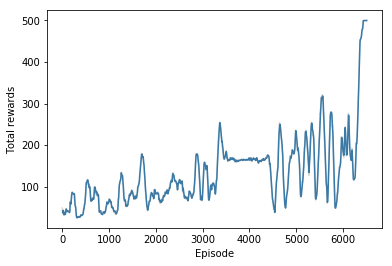

In [35]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

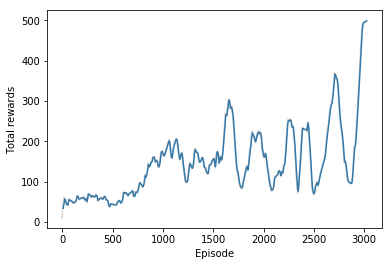

In [30]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

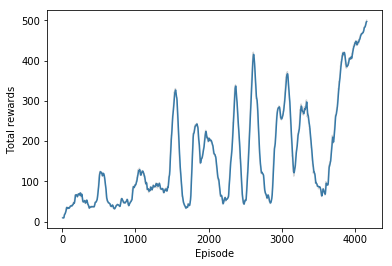

In [32]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

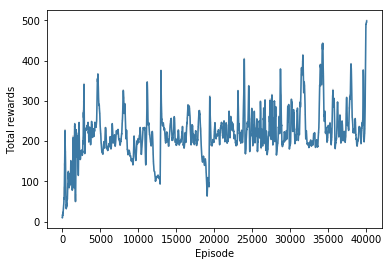

In [29]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

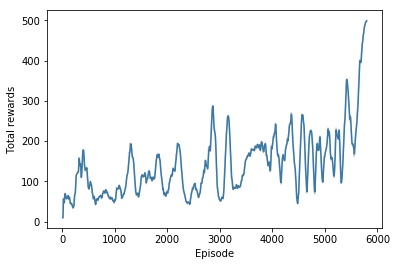

In [184]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

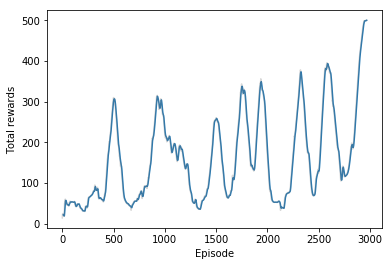

In [178]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

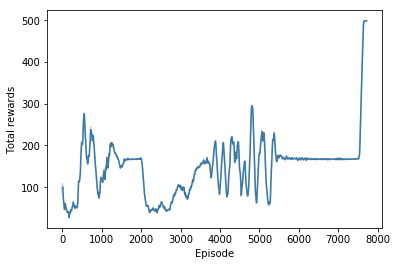

In [173]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

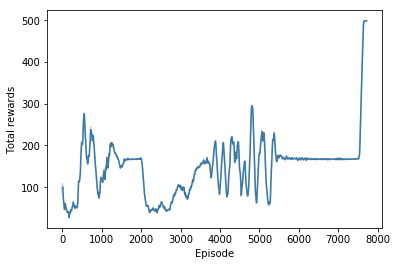

In [172]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

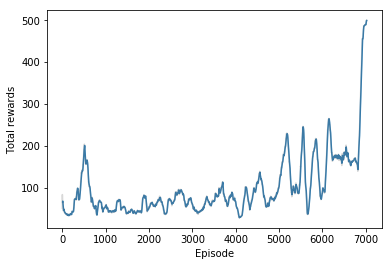

In [166]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

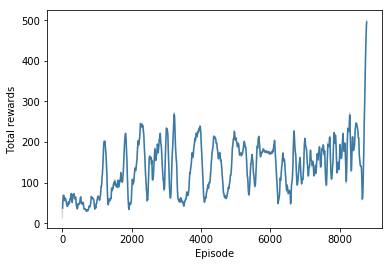

In [161]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

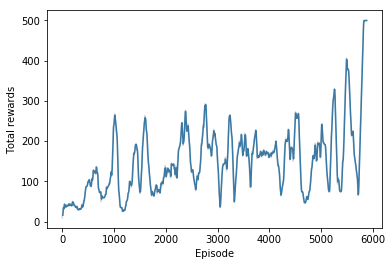

In [157]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

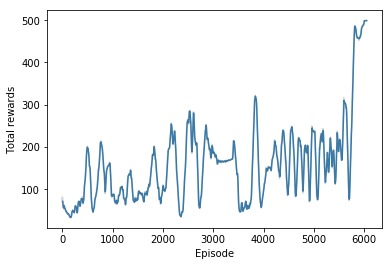

In [154]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Success rates')

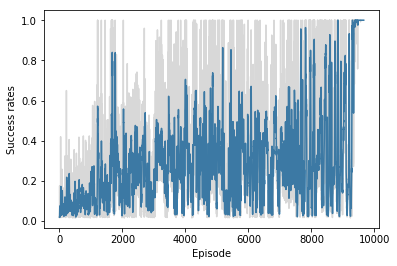

In [134]:
eps, arr = np.array(rates_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Success rates')

Text(0,0.5,'Total rewards')

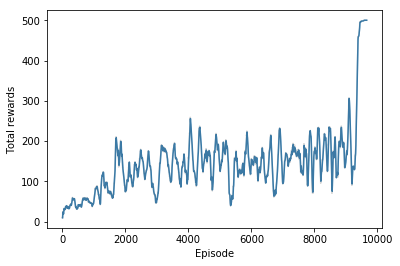

In [126]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Success rates')

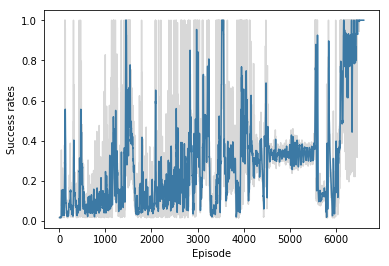

In [104]:
eps, arr = np.array(rates_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Success rates')

Text(0,0.5,'Total rewards')

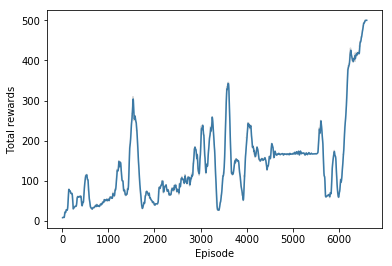

In [102]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

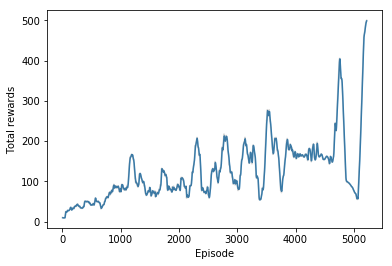

In [82]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

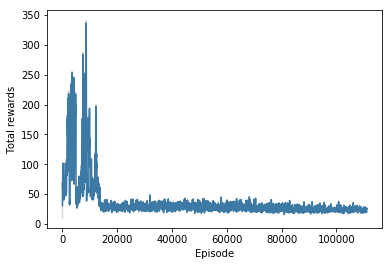

In [67]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

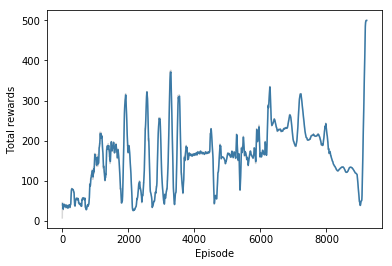

In [52]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

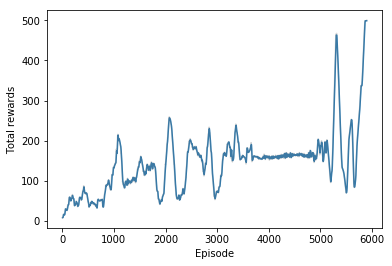

In [28]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

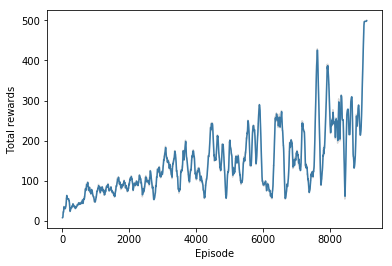

In [29]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

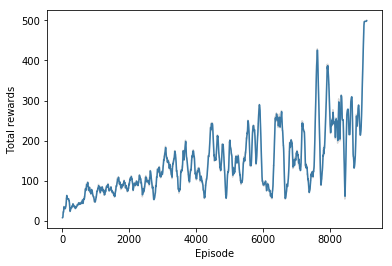

In [27]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

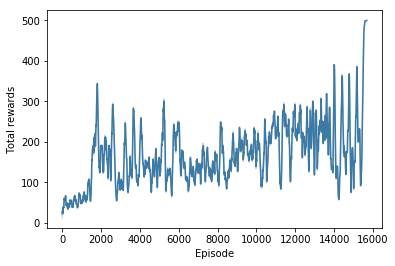

In [46]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

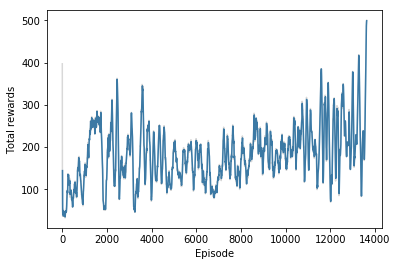

In [32]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

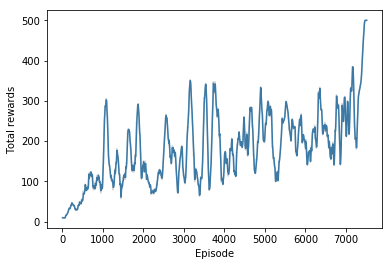

Text(0,0.5,'G losses')

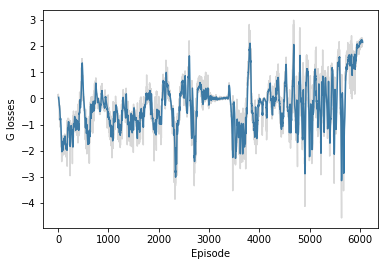

In [149]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'G losses')

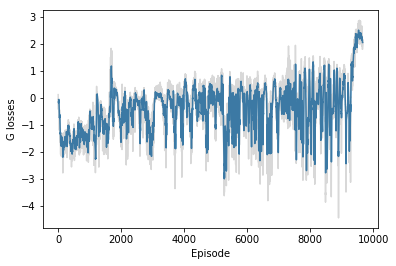

In [130]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'G losses')

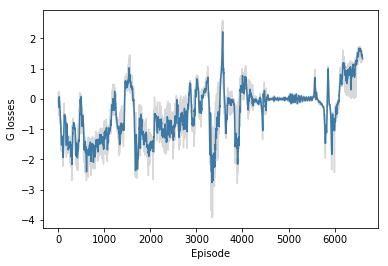

In [105]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'G losses')

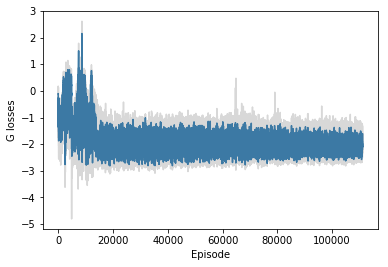

In [68]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'G losses')

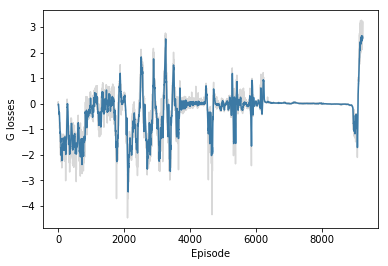

In [53]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'G losses')

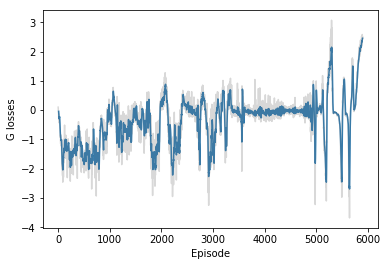

In [29]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'G losses')

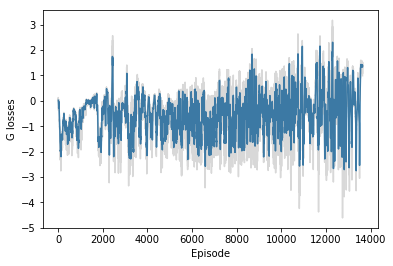

In [33]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'G losses')

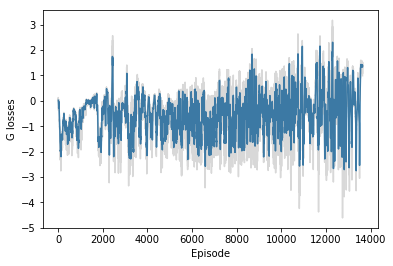

In [30]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

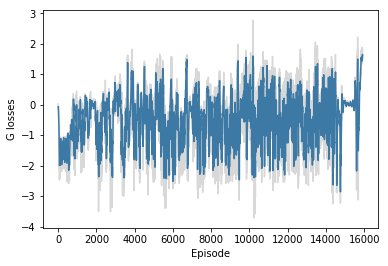
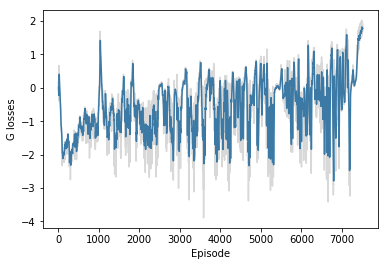

Text(0,0.5,'D losses')

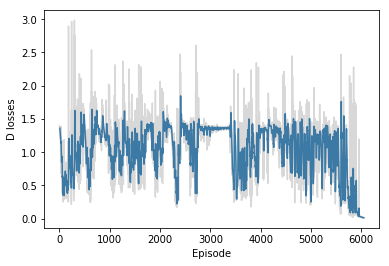

In [150]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

Text(0,0.5,'D losses')

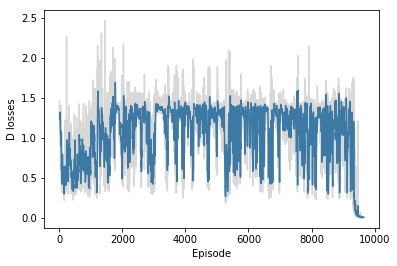

In [131]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

Text(0,0.5,'D losses')

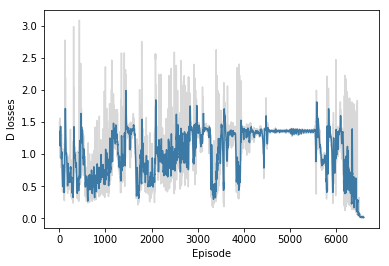

In [106]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

Text(0,0.5,'D losses')

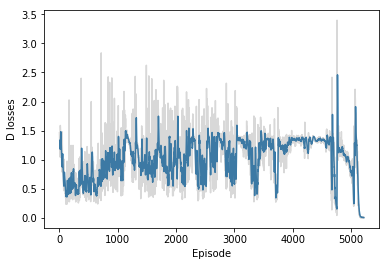

In [83]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

Text(0,0.5,'D losses')

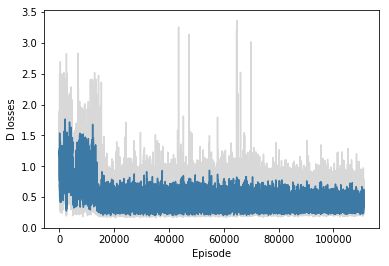

In [69]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

Text(0,0.5,'D losses')

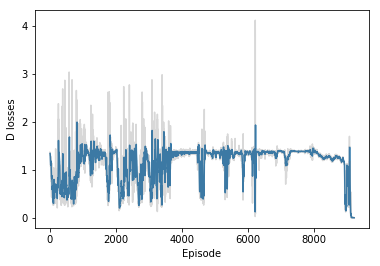

In [54]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

Text(0,0.5,'D losses')

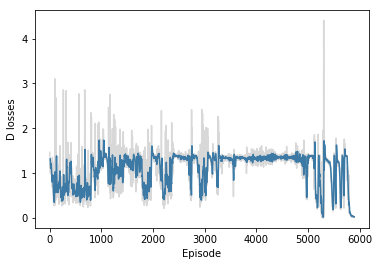

In [30]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

Text(0,0.5,'D losses')

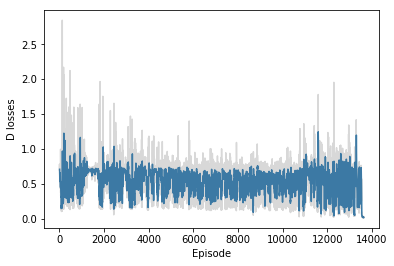

In [34]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

Text(0,0.5,'D losses')

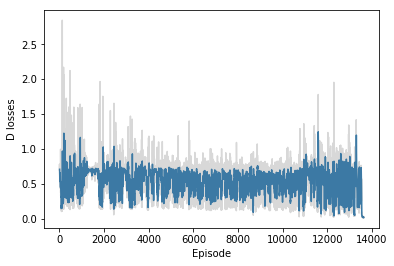

In [31]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

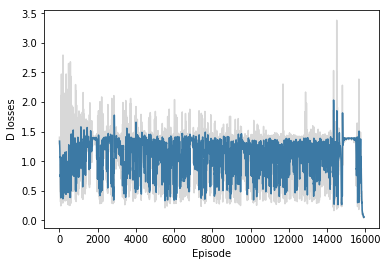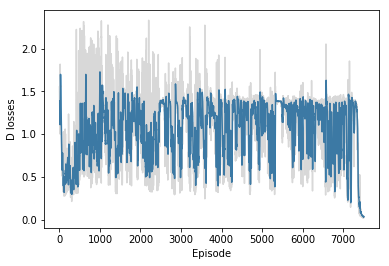

Text(0,0.5,'D losses R')

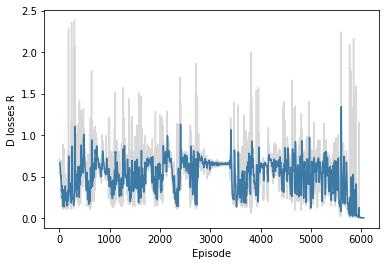

In [152]:
eps, arr = np.array(d_lossR_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses R')

Text(0,0.5,'D losses R')

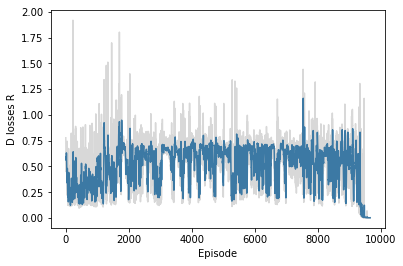

In [132]:
eps, arr = np.array(d_lossR_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses R')

Text(0,0.5,'D losses R')

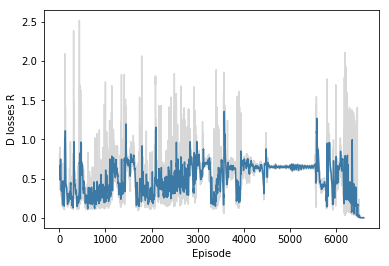

In [107]:
eps, arr = np.array(d_lossR_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses R')

Text(0,0.5,'D losses R')

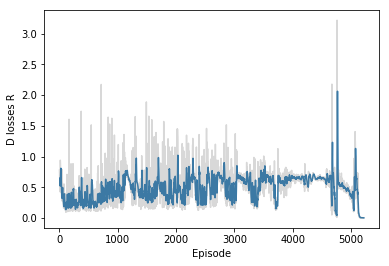

In [84]:
eps, arr = np.array(d_lossR_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses R')

Text(0,0.5,'D losses R')

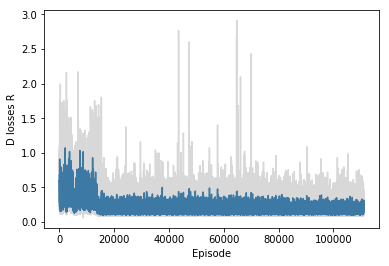

In [70]:
eps, arr = np.array(d_lossR_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses R')

Text(0,0.5,'D losses R')

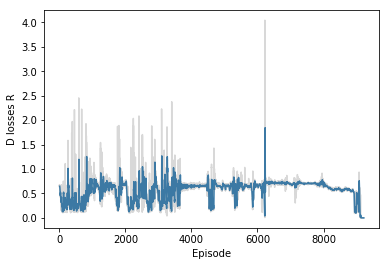

In [55]:
eps, arr = np.array(d_lossR_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses R')

Text(0,0.5,'D losses R')

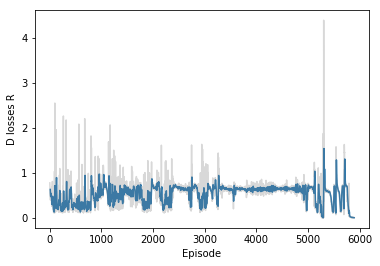

In [31]:
eps, arr = np.array(d_lossR_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses R')

Text(0,0.5,'D losses R')

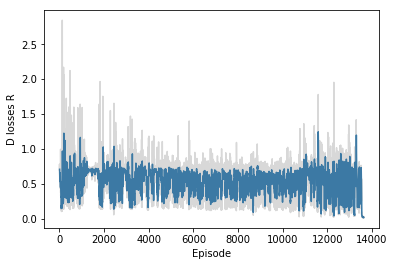

In [35]:
eps, arr = np.array(d_lossR_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses R')

Text(0,0.5,'D losses R')

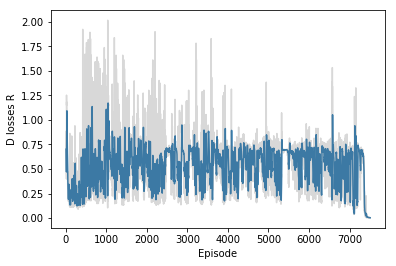

In [32]:
eps, arr = np.array(d_lossR_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses R')

Text(0,0.5,'D losses Q')

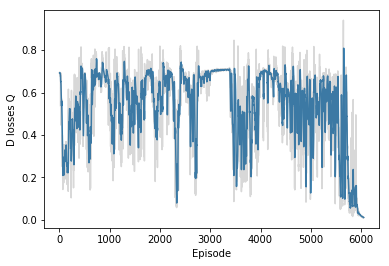

In [153]:
eps, arr = np.array(d_lossQ_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses Q')

Text(0,0.5,'D losses Q')

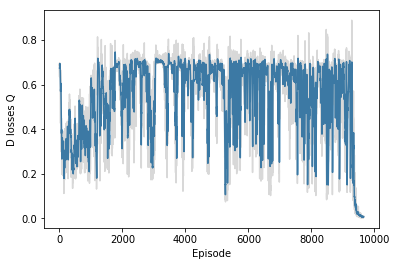

In [133]:
eps, arr = np.array(d_lossQ_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses Q')

Text(0,0.5,'D losses Q')

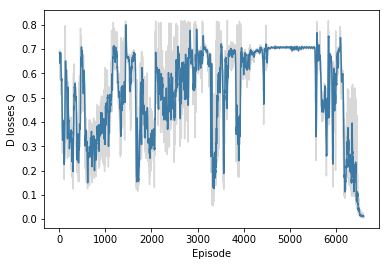

In [108]:
eps, arr = np.array(d_lossQ_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses Q')

Text(0,0.5,'D losses Q')

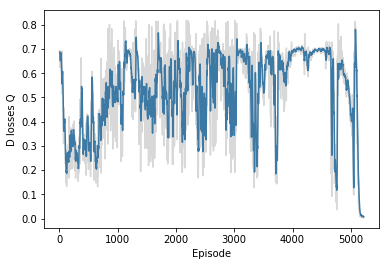

In [85]:
eps, arr = np.array(d_lossQ_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses Q')

Text(0,0.5,'D losses Q')

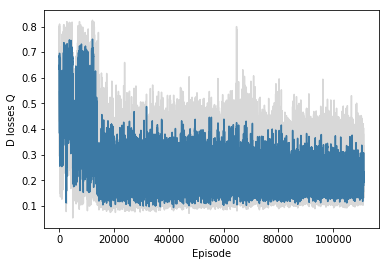

In [71]:
eps, arr = np.array(d_lossQ_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses Q')

Text(0,0.5,'D losses Q')

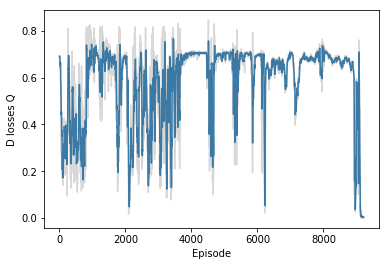

In [56]:
eps, arr = np.array(d_lossQ_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses Q')

Text(0,0.5,'D losses Q')

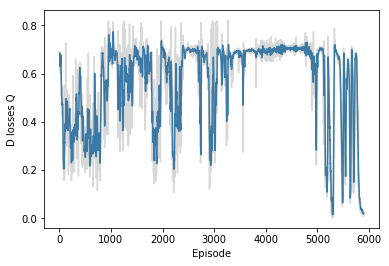

In [32]:
eps, arr = np.array(d_lossQ_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses Q')

Text(0,0.5,'D losses Q')

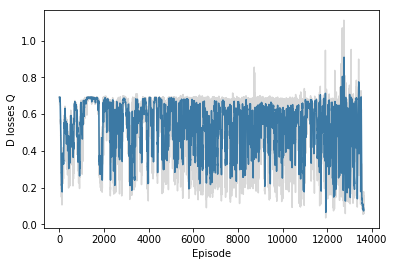

In [36]:
eps, arr = np.array(d_lossQ_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses Q')

Text(0,0.5,'D losses Q')

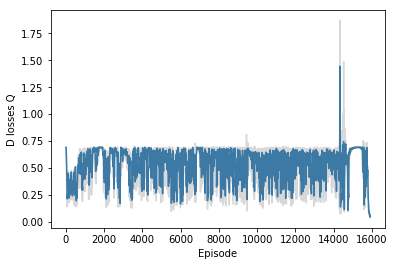

In [33]:
eps, arr = np.array(d_lossQ_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses Q')

Text(0,0.5,'D losses Q')

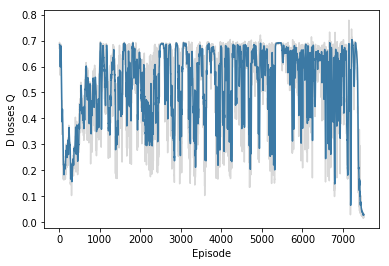

In [33]:
eps, arr = np.array(d_lossQ_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses Q')

## Testing

Let's checkout how our trained agent plays the game.

In [34]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(100):
    #while True:
        state = env.reset()
        total_reward = 0

        # Steps/batches
        #for _ in range(111111111111111111):
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                break
        # Print and break condition
        print('total_reward: {}'.format(total_reward))
        # if total_reward == 500:
        #     break
                
# Closing the env
env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.